# Find feasible bounds for 13C-MFA
The purpose of this notebook is to use FVA to find the bounds of each GSM reaction that are compatible with the measured yields from growth curves


### Load imports

In [1]:
import cobra
import straindesign as sd
import pandas as pd
import sys
from IPython.display import display, Image
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox, TextArea)

source_dir = '../src'
sys.path.append(source_dir)
from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from get_pfba_fva_df import get_pfba_fva_df
from generate_flux_map import generate_flux_map

### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

<Reaction EX_glc_e at 0x134060c70>

### Load 13C-MFA data

In [4]:
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_11022023_GR.xlsx', sheet_name='1102 (not corrected)')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head(5)

There are 43 reactions in the 13C MFA that are mapped to the GSM


Unnamed: 0           ID  \
0                     uptake       uptake   
1                     uptake    R3 glyc3p   
2                     uptake  R3 dhap net   
3                     uptake    OA uptake   
4  glycolysis/gluconeogensis       R4 net   

                                    Equation      reaction_ids  \
0                       Glucose + ATP -> G6P  reverse_EX_glc_e   
1                       GLYC + ATP -> Glyc3P     reverse_GLYCt   
2                     Glyc3P <-> DHAP + UQH2               NaN   
3  OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2           OCDCEAt   
4                                G6P <-> F6P               PGI   

            pathway compartment Location on map  glucose_flux  \
0  substrate_uptake     cytosol   (-1180, 1175)      100.0000   
1               emp     cytosol    (-1376, 417)           NaN   
2               emp     cytosol             NaN           NaN   
3  substrate_uptake     cytosol      (-55, 111)           NaN   
4               emp     cytosol    (-1180, 960)       19.0701   

   glucose_std_err  glucose_LB  ...  glycerol_flux  glycerol_std_err  \
0         3658.800    100.0000  ...            NaN               NaN   
1              NaN         NaN  ...       100.0000          109740.0   
2              NaN         NaN  ...       100.0000          109740.0   
3              NaN         NaN  ...            NaN               NaN   
4          698.003      9.1106  ...       -53.4932           58705.0   

   glycerol_LB  glycerol_UB  glycerol_ΔB  oleic_acid_flux  oleic_acid_std_err  \
0          NaN          NaN          NaN              NaN                 NaN   
1     100.0000     100.0000          NaN              NaN                 NaN   
2     100.0000     100.0000          NaN              NaN                 NaN   
3          NaN          NaN          NaN         100.0000        8.443400e-11   
4     -53.9377     -43.6888      10.2489        -339.5114        8.630700e+00   

   oleic_acid_LB  oleic_acid_UB  oleic_acid_ΔB  
0            NaN            NaN            NaN  
1            NaN            NaN            NaN  
2            NaN            NaN            NaN  
3       100.0000       100.0000            NaN  
4      -364.6709       -68.7166       295.9543  

[5 rows x 22 columns]

### Load growth parameters 

In [5]:
# load the growth parameters from a csv
growth_parameters_df = pd.read_csv('../results/growth_parameters/growth_parameters.csv')
growth_parameters_df.set_index('Unnamed: 0', inplace=True)

growth_parameters_df

glucose  glycerol  oleic_acid
Unnamed: 0                                               
growth_rate                0.266298  0.358041    0.263841
growth_rate_std            0.003048  0.000861    0.005418
yield_coefficient          0.110433  0.058610         NaN
yield_coefficient_std      0.003913  0.009653         NaN
substrate_uptake_rate      2.414362  6.266590         NaN
substrate_uptake_rate_std  0.088704  0.959634         NaN

# Glucose

### Get yield coefficient

In [6]:
# Get glucose yield coefficient
glucose_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glucose']
print(f'glucose yield coefficient: {glucose_yield_coefficient} g biomass per mmol glucose')


glucose yield coefficient: 0.1104330254973178 g biomass per mmol glucose


### Run FVA with yield coefficient

In [7]:
biomass_cutoff = 100 * glucose_yield_coefficient
glucose_gsm_df = get_pfba_fva_df(
    model=model, 
    substrate='glucose', 
    biomass_cutoff=biomass_cutoff,
)
glucose_gsm_df

Running pFBA FVA with the constraints: EX_glc_e = -100, biomass_glucose >= 11.04330254973178, biomass_oil = 0, biomass_C = 0, biomass_N = 0:
ran pfba fva


reaction_id                                      reaction_name  \
0               13BGH                  Endo 1 3 beta glucan glucohydrase   
1              13BGHe                   Exo 1 3 beta glucan glucohydrase   
2               ASADi  aspartate semialdehyde dehydrogenase irreversible   
3            2DDA7Ptm  2 Dehydro 3 deoxy D arabino heptonate7 phohsph...   
4              2DHPtm          2 Dehydropantoate mitochondrial transport   
...               ...                                                ...   
1345      erythritolT                                        erythritolT   
1346      EX_eryth(e)                                        EX_eryth(e)   
1347          EX_biom                                            EX_biom   
1348  biomass_glucose                                                      
1349      biomass_oil                                                      

                                          full_reaction  glucose_GSM_flux  \
0                     13BDglcn[c] + h2o[c] --> glc_D[c]          0.000000   
1                     13BDglcn[e] + h2o[e] --> glc_D[e]          0.000000   
2     4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...          4.327208   
3                               2dda7p[c] <=> 2dda7p[m]         -1.578903   
4                                   2dhp[c] <=> 2dhp[m]          0.000000   
...                                                 ...               ...   
1345                    erythritol[c] <=> erythritol[e]          0.000000   
1346                                 erythritol[e] -->           0.000000   
1347                                    biomass[c] -->          12.749805   
1348  0.6822317267700153 13BDglcn[c] + 0.55815800338...         12.749805   
1349  0.6822317267700153 13BDglcn[c] + 0.32998465303...          0.000000   

      glucose_GSM_LB  glucose_GSM_UB  
0           0.000000      114.437786  
1           0.000000       -0.000000  
2           3.748031       57.941535  
3         -24.448072       -0.000000  
4           0.000000        7.603151  
...              ...             ...  
1345        0.000000       18.645668  
1346        0.000000       18.645668  
1347       11.043303       12.749805  
1348       11.043303       12.749805  
1349        0.000000       -0.000000  

[1350 rows x 6 columns]

### Define a function to check if MFA bounds are feasible with GSM bounds

In [8]:
# Define a function to check feasibility
def check_feasibility(gsm_bounds, mfa_bounds):
    
    gsm_lb = float(gsm_bounds[0])
    gsm_ub = float(gsm_bounds[1])
    mfa_lb = float(mfa_bounds[0])
    mfa_ub = float(mfa_bounds[1])

    if mfa_lb >= gsm_lb and mfa_ub <= gsm_ub:
        return 'fully feasible'
    elif mfa_ub < gsm_lb or mfa_lb > gsm_ub:
        return 'not feasible'
    else:
        return 'partially feasible'


def add_mfa_bound_feasibility_column(full_central_rxn_df, substrate):
    mfa_bound_feasibilities = []
    gsm_lb, gsm_ub = f'{substrate}_GSM_LB', f'{substrate}_GSM_UB'
    mfa_lb, mfa_ub = f'{substrate}_LB', f'{substrate}_UB'
    feasibility_column = f'{substrate}_mfa_bound_feasibility'

    # loop over flux rows
    for index, row in full_central_rxn_df.iterrows():
        # get the MFA and GSM flux bounds
        gsm_flux_bounds = [row[gsm_lb], row[gsm_ub]]
        mfa_flux_bounds = [row[mfa_lb], row[mfa_ub]]

        gsm_flux_bounds = pd.to_numeric(gsm_flux_bounds, errors='coerce')
        mfa_flux_bounds = pd.to_numeric(mfa_flux_bounds, errors='coerce')

        if any(pd.isna(gsm_flux_bounds)) or any(pd.isna(mfa_flux_bounds)):
            mfa_bound_feasibilities.append('')
            continue

        mfa_bound_feasibility = check_feasibility(gsm_flux_bounds, mfa_flux_bounds)
        mfa_bound_feasibilities.append(mfa_bound_feasibility)

    full_central_rxn_df[feasibility_column] = mfa_bound_feasibilities

    return full_central_rxn_df

### Add glucose FVA data to the central pathway dataframe

In [9]:
full_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
full_central_rxn_df = add_flux_column_to_13c_flux_df(full_central_rxn_df, glucose_gsm_df, 'glucose_GSM_flux')
full_central_rxn_df = add_fva_columns_to_13c_flux_df(full_central_rxn_df, glucose_gsm_df, 'glucose_GSM_LB', 'glucose_GSM_UB')
full_central_rxn_df = add_mfa_bound_feasibility_column(full_central_rxn_df, 'glucose')

full_central_rxn_df

Unnamed: 0           ID  \
0                      uptake       uptake   
1                      uptake    R3 glyc3p   
2                      uptake  R3 dhap net   
3                      uptake    OA uptake   
4   glycolysis/gluconeogensis       R4 net   
..                        ...          ...   
66          biomass formation          R80   
67          energy metabolism          R81   
68          energy metabolism          R82   
69          energy metabolism          R83   
70              co2_formation          R79   

                                     Equation  \
0                        Glucose + ATP -> G6P   
1                        GLYC + ATP -> Glyc3P   
2                      Glyc3P <-> DHAP + UQH2   
3   OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2   
4                                 G6P <-> F6P   
..                                        ...   
66                                        NaN   
67                     ATP -> ATP_maintenance   
68                              NADH -> NADPH   
69                              NADH -> 2*ATP   
70                              CO2 -> CO2_EX   

                                   reaction_ids            pathway  \
0                              reverse_EX_glc_e   substrate_uptake   
1                                 reverse_GLYCt                emp   
2                                           NaN                emp   
3                                       OCDCEAt   substrate_uptake   
4                                           PGI                emp   
..                                          ...                ...   
66  biomass_C or biomass_glucose or biomass_oil  biomass_formation   
67                                         ATPM  energy_metabolism   
68                                          NaN                NaN   
69                                          NaN                NaN   
70                                 reverse_CO2t          transport   

      compartment Location on map  glucose_flux  glucose_std_err  glucose_LB  \
0         cytosol   (-1180, 1175)      100.0000        3658.8000    100.0000   
1         cytosol    (-1376, 417)           NaN              NaN         NaN   
2         cytosol             NaN           NaN              NaN         NaN   
3         cytosol      (-55, 111)           NaN              NaN         NaN   
4         cytosol    (-1180, 960)       19.0701         698.0030      9.1106   
..            ...             ...           ...              ...         ...   
66        cytosol  (-1670, -1049)       11.2586         411.9407      9.8463   
67        cytosol             NaN      613.4628       22445.0000    436.2967   
68            NaN             NaN       33.5917       27366.0000      0.0000   
69            NaN             NaN      280.3469       10257.0000    210.3067   
70  extracellular  (-1670, -1155)      198.2584        7253.6000    161.2777   

    ...  glycerol_ΔB  oleic_acid_flux  oleic_acid_std_err  oleic_acid_LB  \
0   ...          NaN              NaN                 NaN            NaN   
1   ...          NaN              NaN                 NaN            NaN   
2   ...          NaN              NaN                 NaN            NaN   
3   ...          NaN     1.000000e+02        8.443400e-11       100.0000   
4   ...      10.2489    -3.395114e+02        8.630700e+00      -364.6709   
..  ...          ...              ...                 ...            ...   
66  ...       0.3908     3.331210e+01        1.074500e+00        30.1667   
67  ...      65.8964     2.733800e+03        2.080376e+02       987.0940   
68  ...      22.0001     8.910500e-07        1.218800e-11         0.0000   
69  ...      28.1508     1.199500e+03        7.203330e+01            NaN   
70  ...      13.9501     6.405070e+02        3.740130e+01            NaN   

    oleic_acid_UB  oleic_acid_ΔB  glucose_GSM_flux  glucose_GSM_LB  \
0             NaN            NaN             100.0           100.0   
1             NaN     

### Plot glucose MFA data

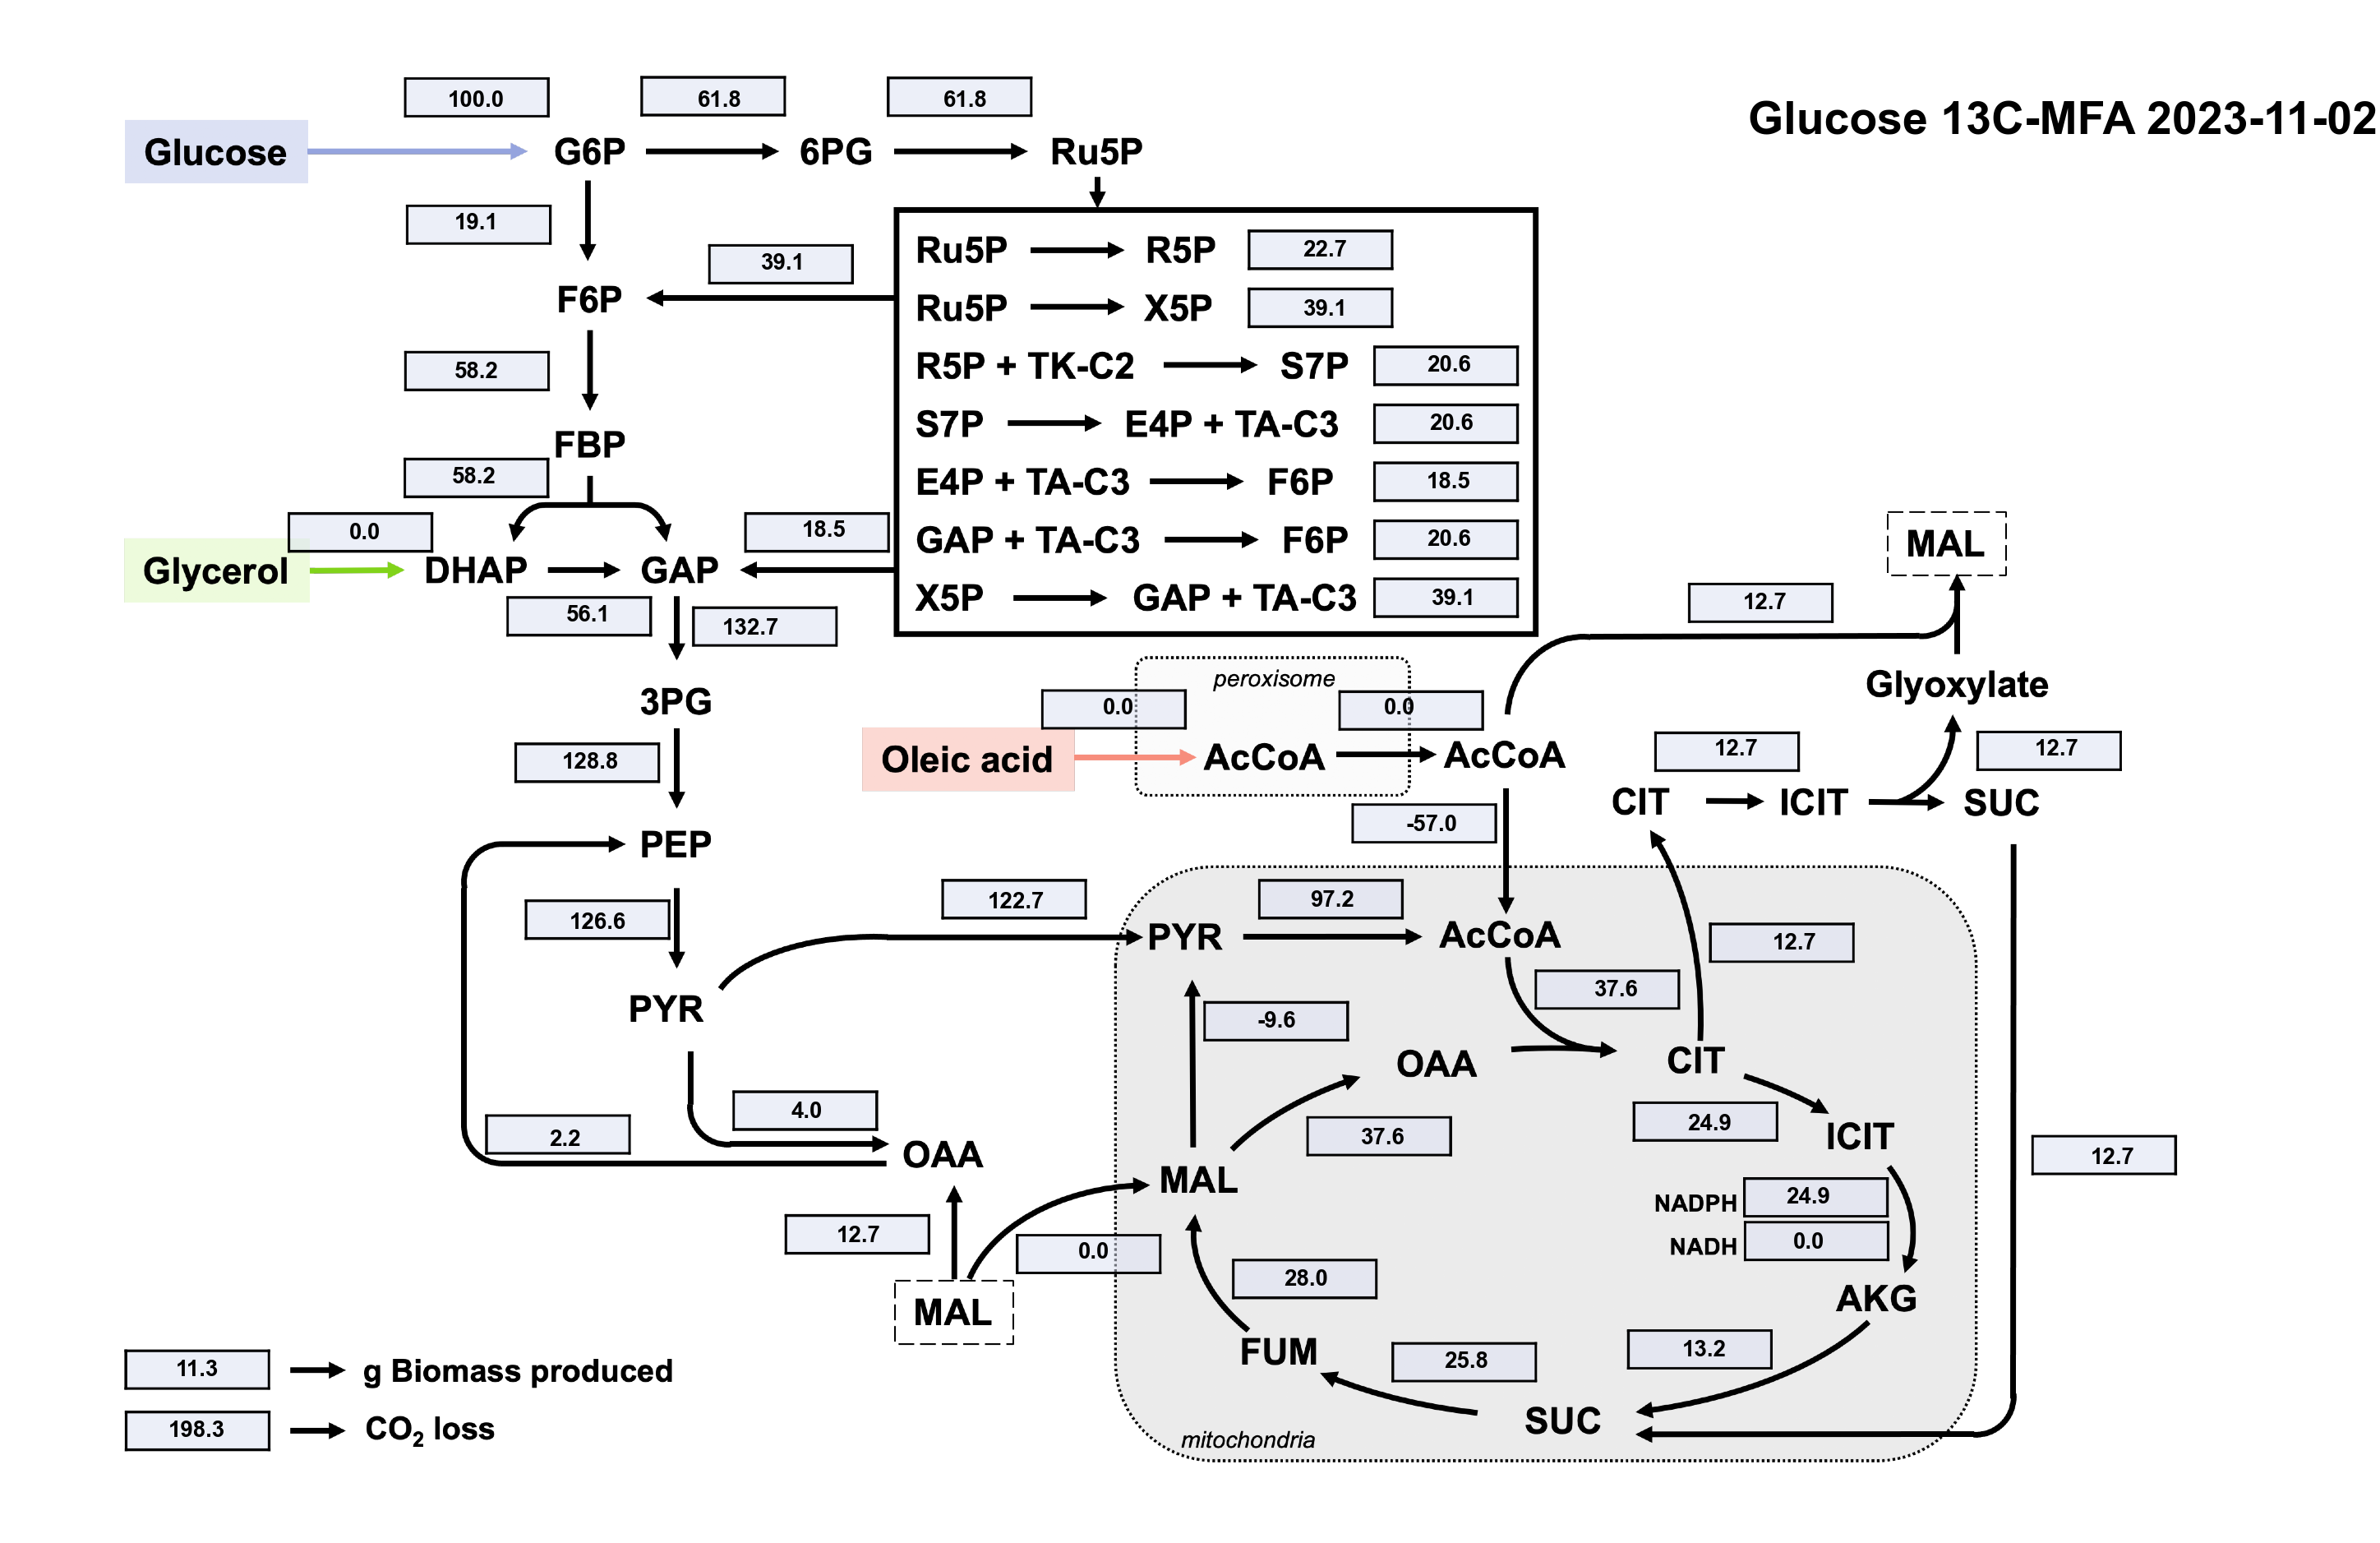

In [10]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column='glucose_flux', 
    title_string='Glucose 13C-MFA 2023-11-02',
    file_name='../figures/test_flux_map.png',
)

### Plot Glucose GSM fluxes

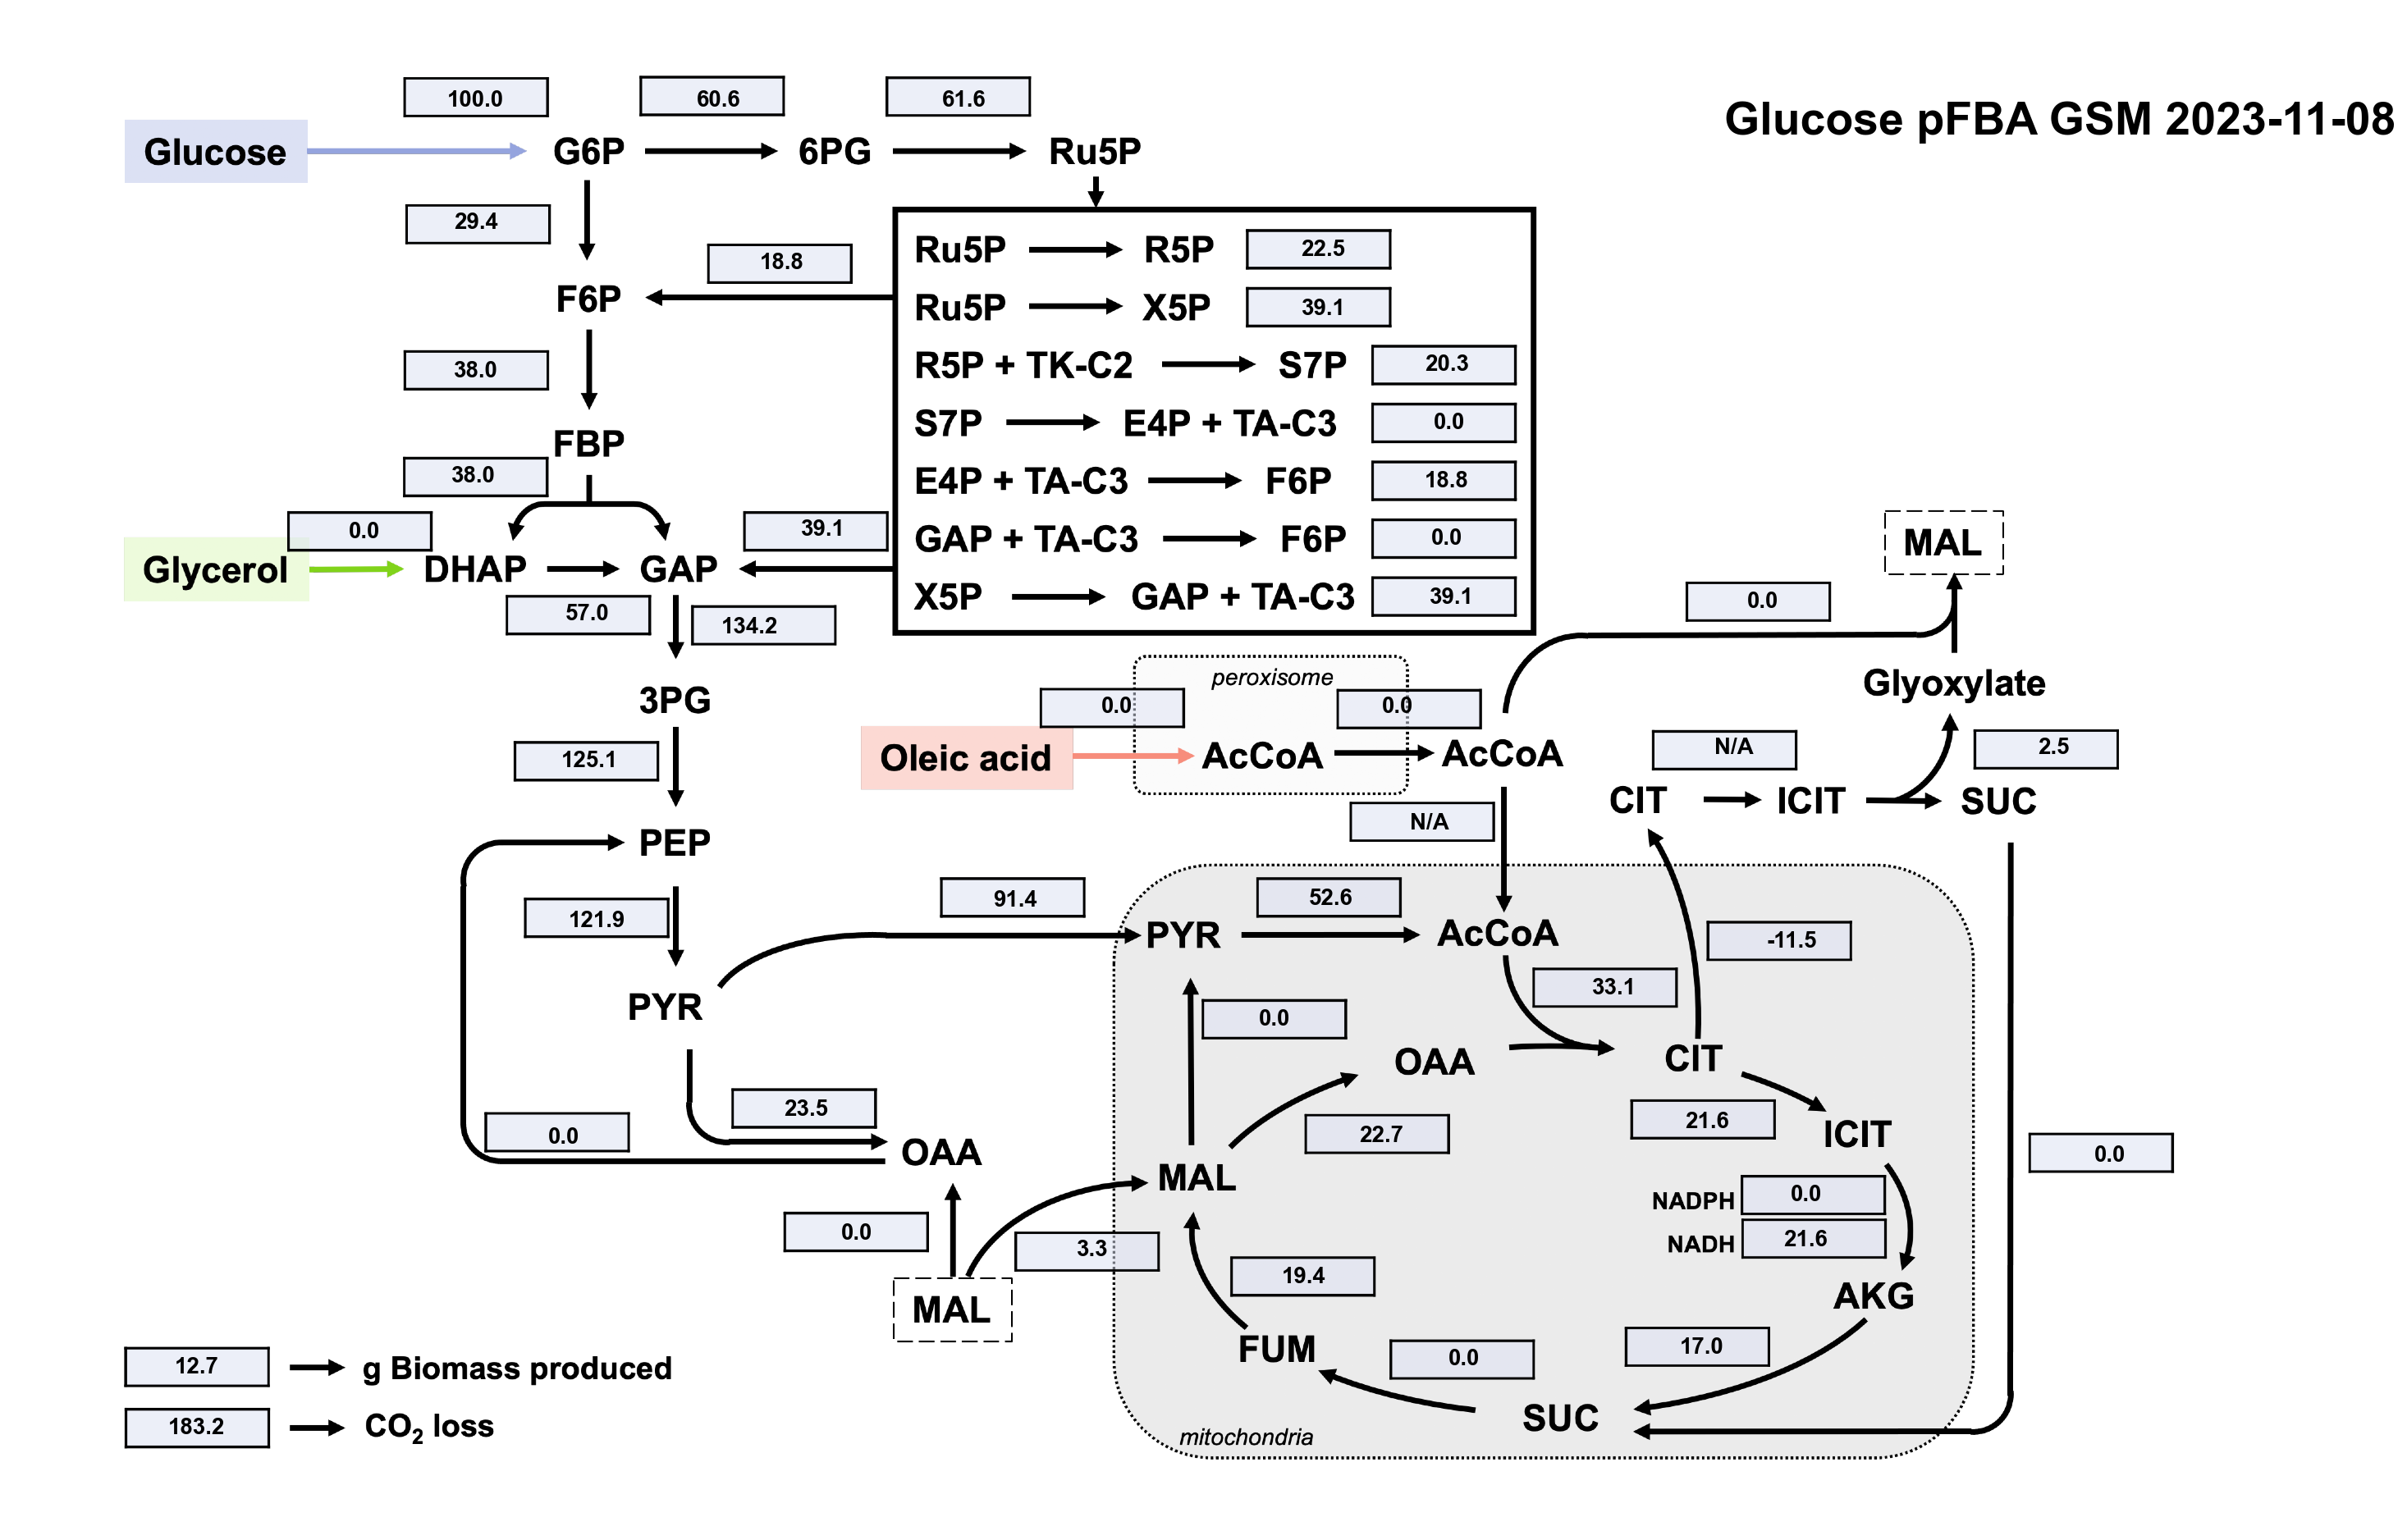

In [11]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column='glucose_GSM_flux', 
    title_string='Glucose pFBA GSM 2023-11-08',
    file_name='../figures/test_flux_map.png',
)

### Plot Glucose MFA bounds

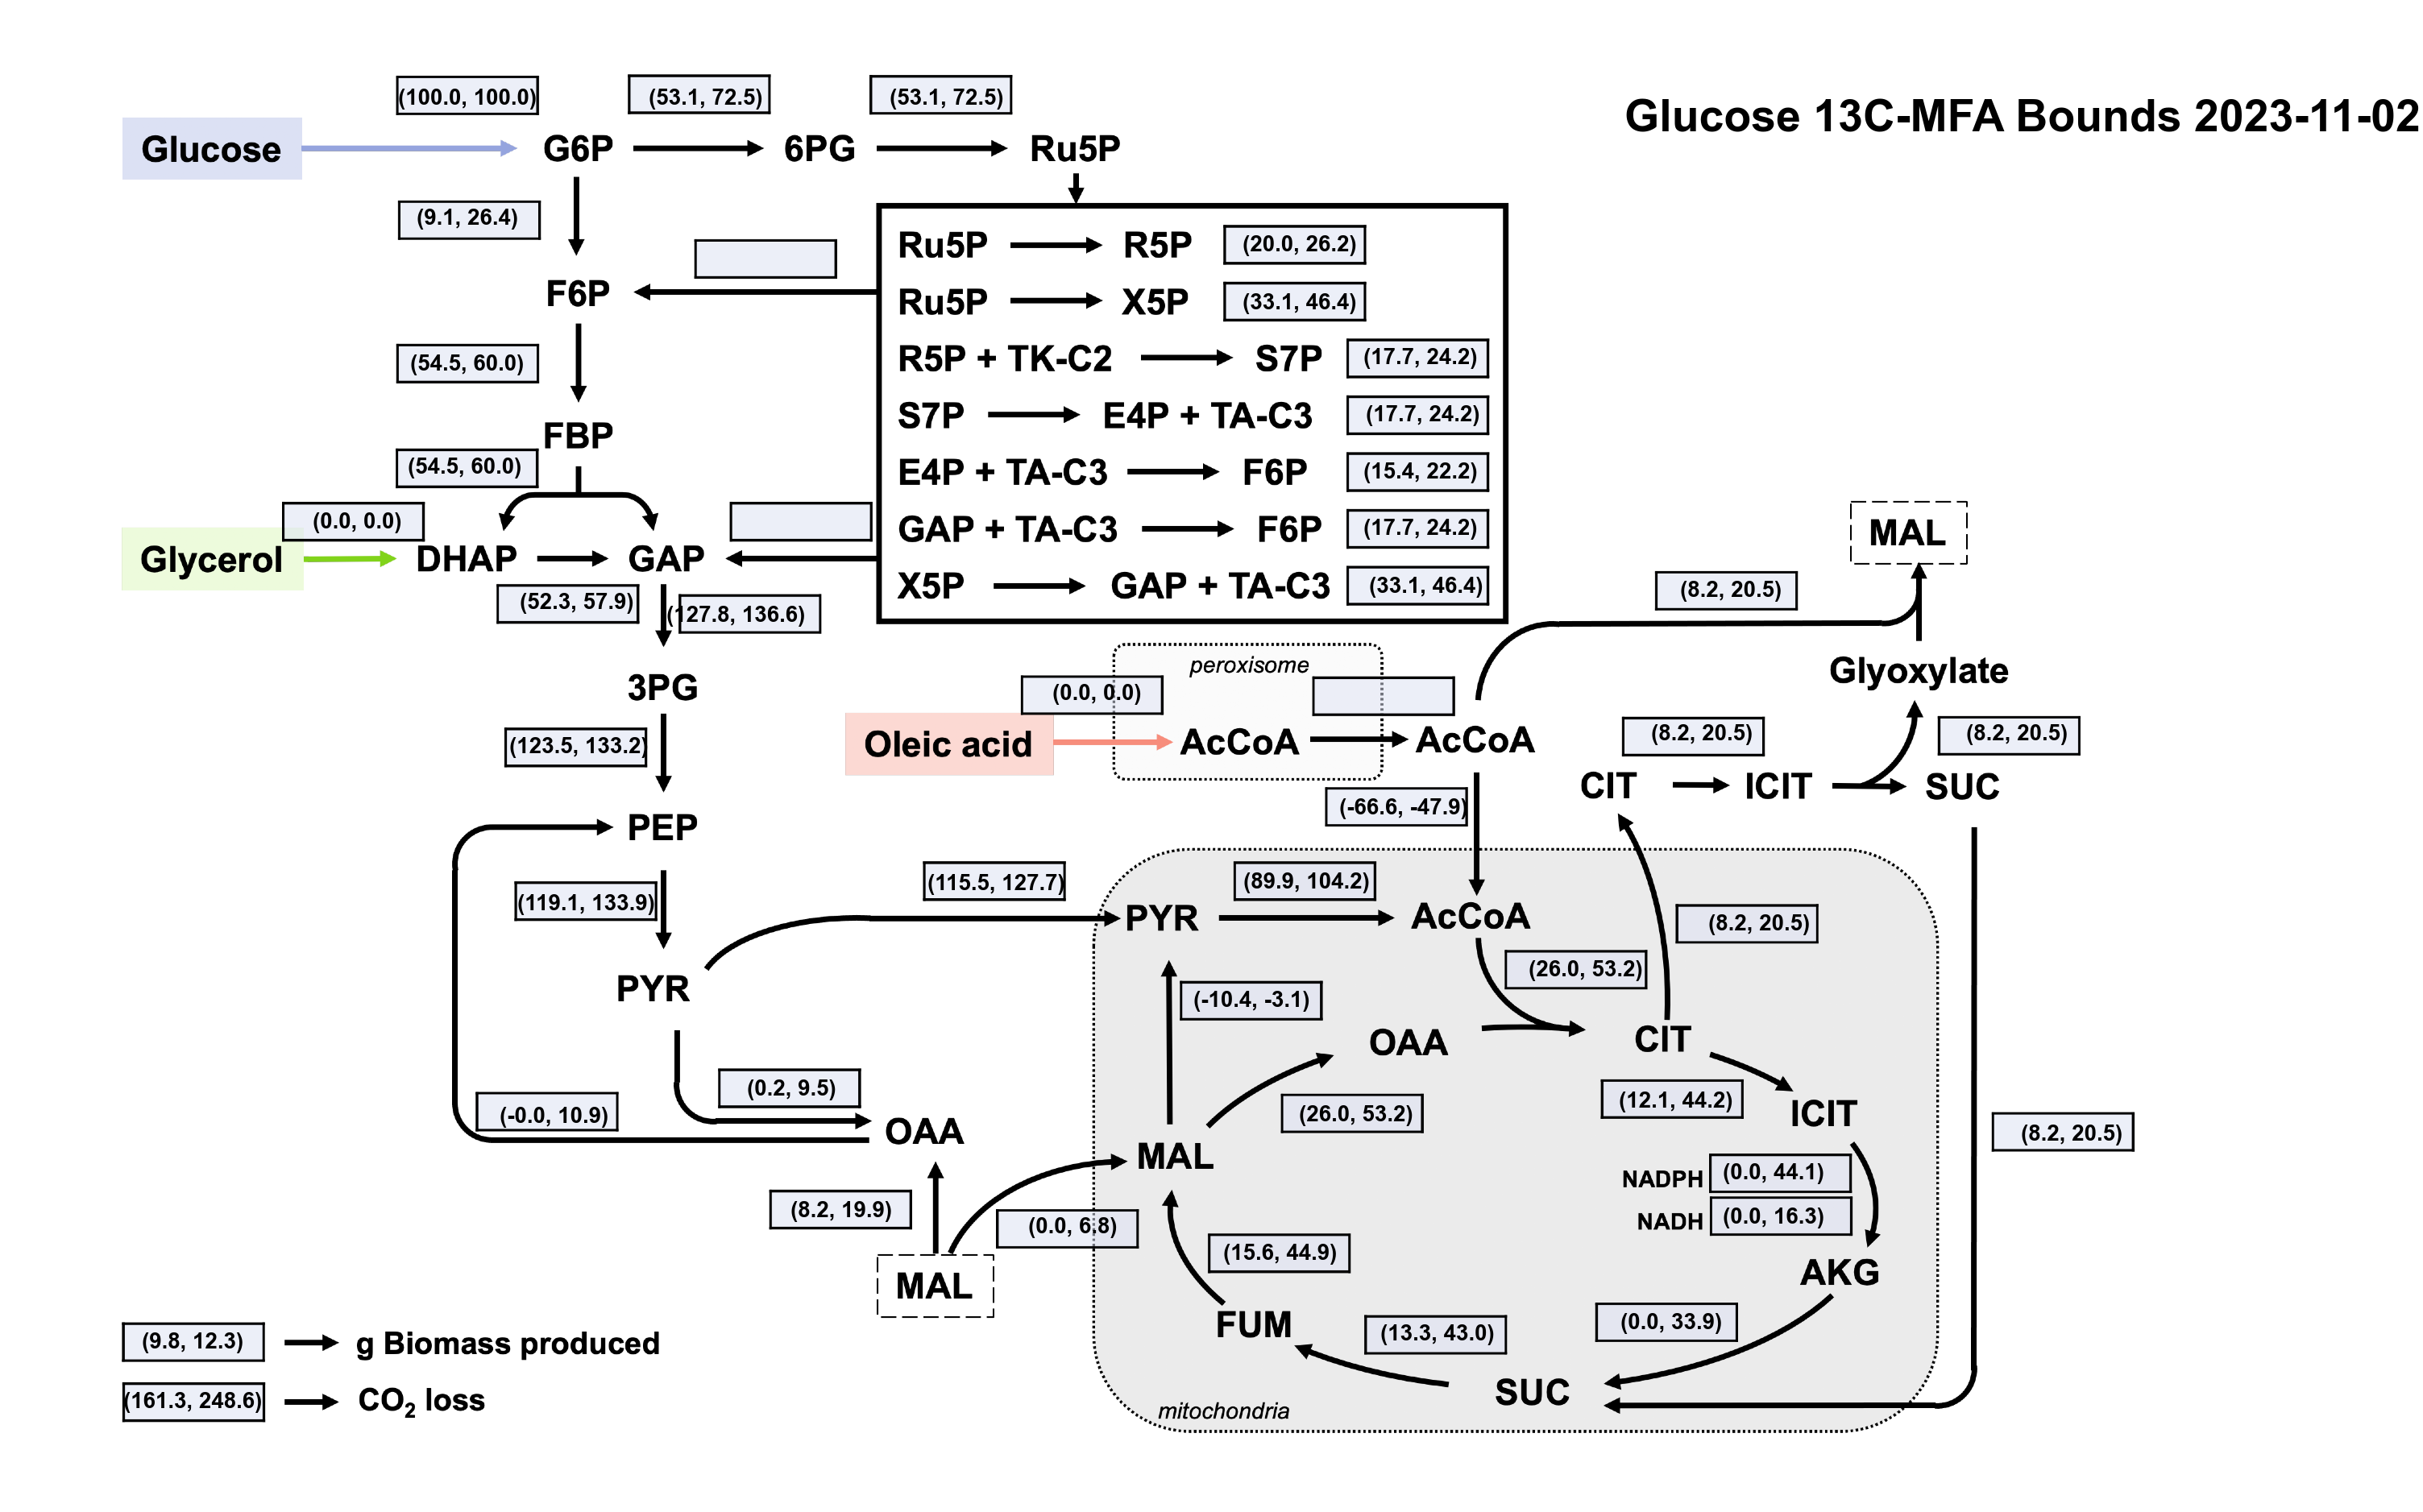

In [12]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column=['glucose_LB', 'glucose_UB'],
    title_string='Glucose 13C-MFA Bounds 2023-11-02',
    file_name='../figures/test_flux_map.png',
)

### Plot glucose GSM bounds

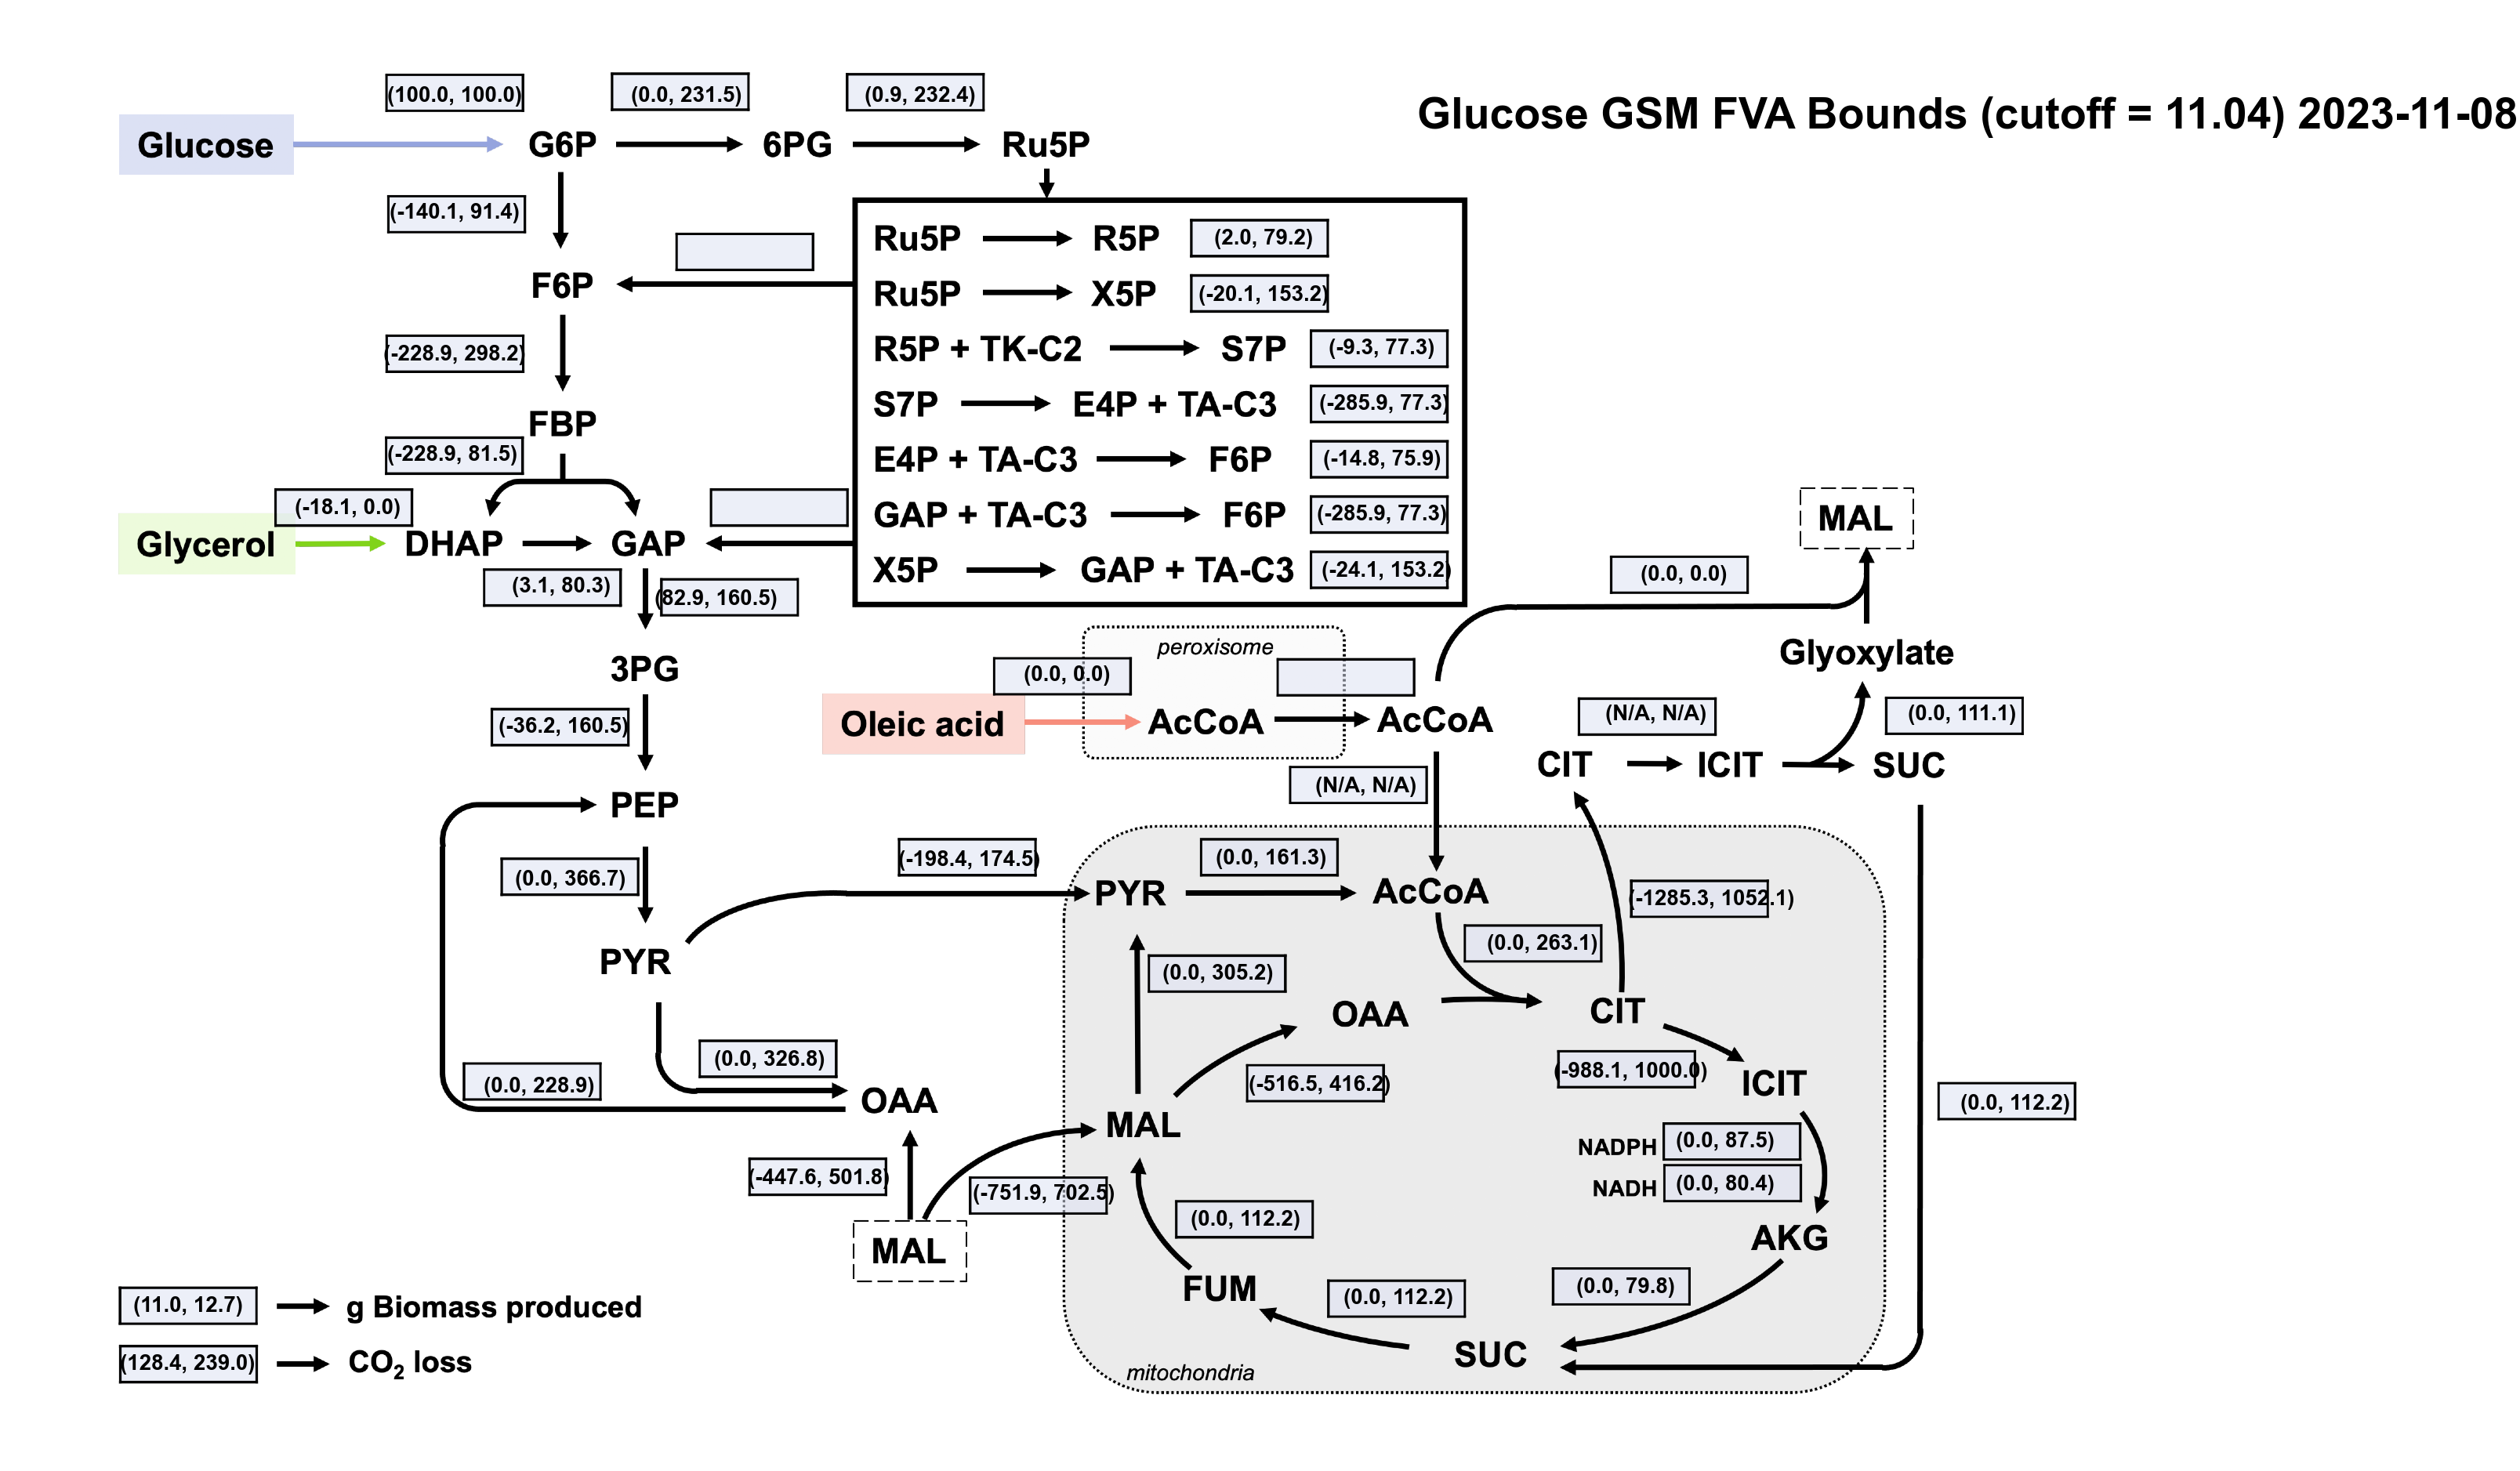

In [13]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column=['glucose_GSM_LB', 'glucose_GSM_UB'],
    title_string=f'Glucose GSM FVA Bounds (cutoff = {biomass_cutoff:.2f}) 2023-11-08',
    file_name='../figures/test_flux_map.png',
)

# Glycerol

### Get yield coefficient

In [14]:
# Get glycerol yield coefficient
glycerol_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glycerol']
print(f'glycerol yield coefficient: {glycerol_yield_coefficient} g biomass per mmol glycerol')


glycerol yield coefficient: 0.0586097809126681 g biomass per mmol glycerol


### Run FVA with yield coefficient

In [15]:
# biomass_cutoff = 100 * glycerol_yield_coefficient
biomass_cutoff = 5
glycerol_gsm_df = get_pfba_fva_df(
    model=model, 
    substrate='glycerol', 
    biomass_cutoff=biomass_cutoff
)
glycerol_gsm_df

Running pFBA FVA with the constraints: EX_glyc_e = -100, biomass_glucose >= 5, biomass_oil = 0, biomass_C = 0, biomass_N = 0:
ran pfba fva


reaction_id                                      reaction_name  \
0               13BGH                  Endo 1 3 beta glucan glucohydrase   
1              13BGHe                   Exo 1 3 beta glucan glucohydrase   
2               ASADi  aspartate semialdehyde dehydrogenase irreversible   
3            2DDA7Ptm  2 Dehydro 3 deoxy D arabino heptonate7 phohsph...   
4              2DHPtm          2 Dehydropantoate mitochondrial transport   
...               ...                                                ...   
1345      erythritolT                                        erythritolT   
1346      EX_eryth(e)                                        EX_eryth(e)   
1347          EX_biom                                            EX_biom   
1348  biomass_glucose                                                      
1349      biomass_oil                                                      

                                          full_reaction  glycerol_GSM_flux  \
0                     13BDglcn[c] + h2o[c] --> glc_D[c]           0.000000   
1                     13BDglcn[e] + h2o[e] --> glc_D[e]           0.000000   
2     4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...           1.761357   
3                               2dda7p[c] <=> 2dda7p[m]           0.000000   
4                                   2dhp[c] <=> 2dhp[m]           0.000000   
...                                                 ...                ...   
1345                    erythritol[c] <=> erythritol[e]           0.000000   
1346                                 erythritol[e] -->            0.000000   
1347                                    biomass[c] -->            5.189712   
1348  0.6822317267700153 13BDglcn[c] + 0.55815800338...           5.189712   
1349  0.6822317267700153 13BDglcn[c] + 0.32998465303...           0.000000   

      glycerol_GSM_LB  glycerol_GSM_UB  
0            0.000000        13.793681  
1            0.000000        -0.000000  
2            1.696970         8.895726  
3           -3.277766        -0.000000  
4            0.000000         0.767065  
...               ...              ...  
1345         0.000000         2.437031  
1346         0.000000         2.437031  
1347         5.000000         5.189712  
1348         5.000000         5.189712  
1349         0.000000        -0.000000  

[1350 rows x 6 columns]

### Add glycerol FVA data to the central pathway dataframe

In [16]:
# add pfba flux column
full_central_rxn_df = add_flux_column_to_13c_flux_df(full_central_rxn_df, glycerol_gsm_df, 'glycerol_GSM_flux')
full_central_rxn_df = add_fva_columns_to_13c_flux_df(full_central_rxn_df, glycerol_gsm_df, 'glycerol_GSM_LB', 'glycerol_GSM_UB')
full_central_rxn_df = add_mfa_bound_feasibility_column(full_central_rxn_df, 'glycerol')

full_central_rxn_df

Unnamed: 0           ID  \
0                      uptake       uptake   
1                      uptake    R3 glyc3p   
2                      uptake  R3 dhap net   
3                      uptake    OA uptake   
4   glycolysis/gluconeogensis       R4 net   
..                        ...          ...   
66          biomass formation          R80   
67          energy metabolism          R81   
68          energy metabolism          R82   
69          energy metabolism          R83   
70              co2_formation          R79   

                                     Equation  \
0                        Glucose + ATP -> G6P   
1                        GLYC + ATP -> Glyc3P   
2                      Glyc3P <-> DHAP + UQH2   
3   OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2   
4                                 G6P <-> F6P   
..                                        ...   
66                                        NaN   
67                     ATP -> ATP_maintenance   
68                              NADH -> NADPH   
69                              NADH -> 2*ATP   
70                              CO2 -> CO2_EX   

                                   reaction_ids            pathway  \
0                              reverse_EX_glc_e   substrate_uptake   
1                                 reverse_GLYCt                emp   
2                                           NaN                emp   
3                                       OCDCEAt   substrate_uptake   
4                                           PGI                emp   
..                                          ...                ...   
66  biomass_C or biomass_glucose or biomass_oil  biomass_formation   
67                                         ATPM  energy_metabolism   
68                                          NaN                NaN   
69                                          NaN                NaN   
70                                 reverse_CO2t          transport   

      compartment Location on map  glucose_flux  glucose_std_err  glucose_LB  \
0         cytosol   (-1180, 1175)      100.0000        3658.8000    100.0000   
1         cytosol    (-1376, 417)           NaN              NaN         NaN   
2         cytosol             NaN           NaN              NaN         NaN   
3         cytosol      (-55, 111)           NaN              NaN         NaN   
4         cytosol    (-1180, 960)       19.0701         698.0030      9.1106   
..            ...             ...           ...              ...         ...   
66        cytosol  (-1670, -1049)       11.2586         411.9407      9.8463   
67        cytosol             NaN      613.4628       22445.0000    436.2967   
68            NaN             NaN       33.5917       27366.0000      0.0000   
69            NaN             NaN      280.3469       10257.0000    210.3067   
70  extracellular  (-1670, -1155)      198.2584        7253.6000    161.2777   

    ...  oleic_acid_UB  oleic_acid_ΔB  glucose_GSM_flux  glucose_GSM_LB  \
0   ...            NaN            NaN             100.0           100.0   
1   ...            NaN            NaN               0.0      -18.057244   
2   ...            NaN            NaN                                     
3   ...       100.0000            NaN               0.0             0.0   
4   ...       -68.7166       295.9543          29.43415      -140.11044   
..  ...            ...            ...               ...             ...   
66  ...        43.4949        13.3282         12.749805       11.043303   
67  ...      3299.4000      2312.3060               0.0             0.0   
68  ...       774.6812       774.6812                                     
69  ...      1408.1000            NaN                                     
70  ...       749.9952            NaN          183.2194      128.415579   

    glucose_GSM_UB  glucose_mfa_bound_feasibility  glycerol_GSM_flux  \
0            100.0                 fully feasible                0.0   
1              0.0            

### Plot glycerol MFA flux

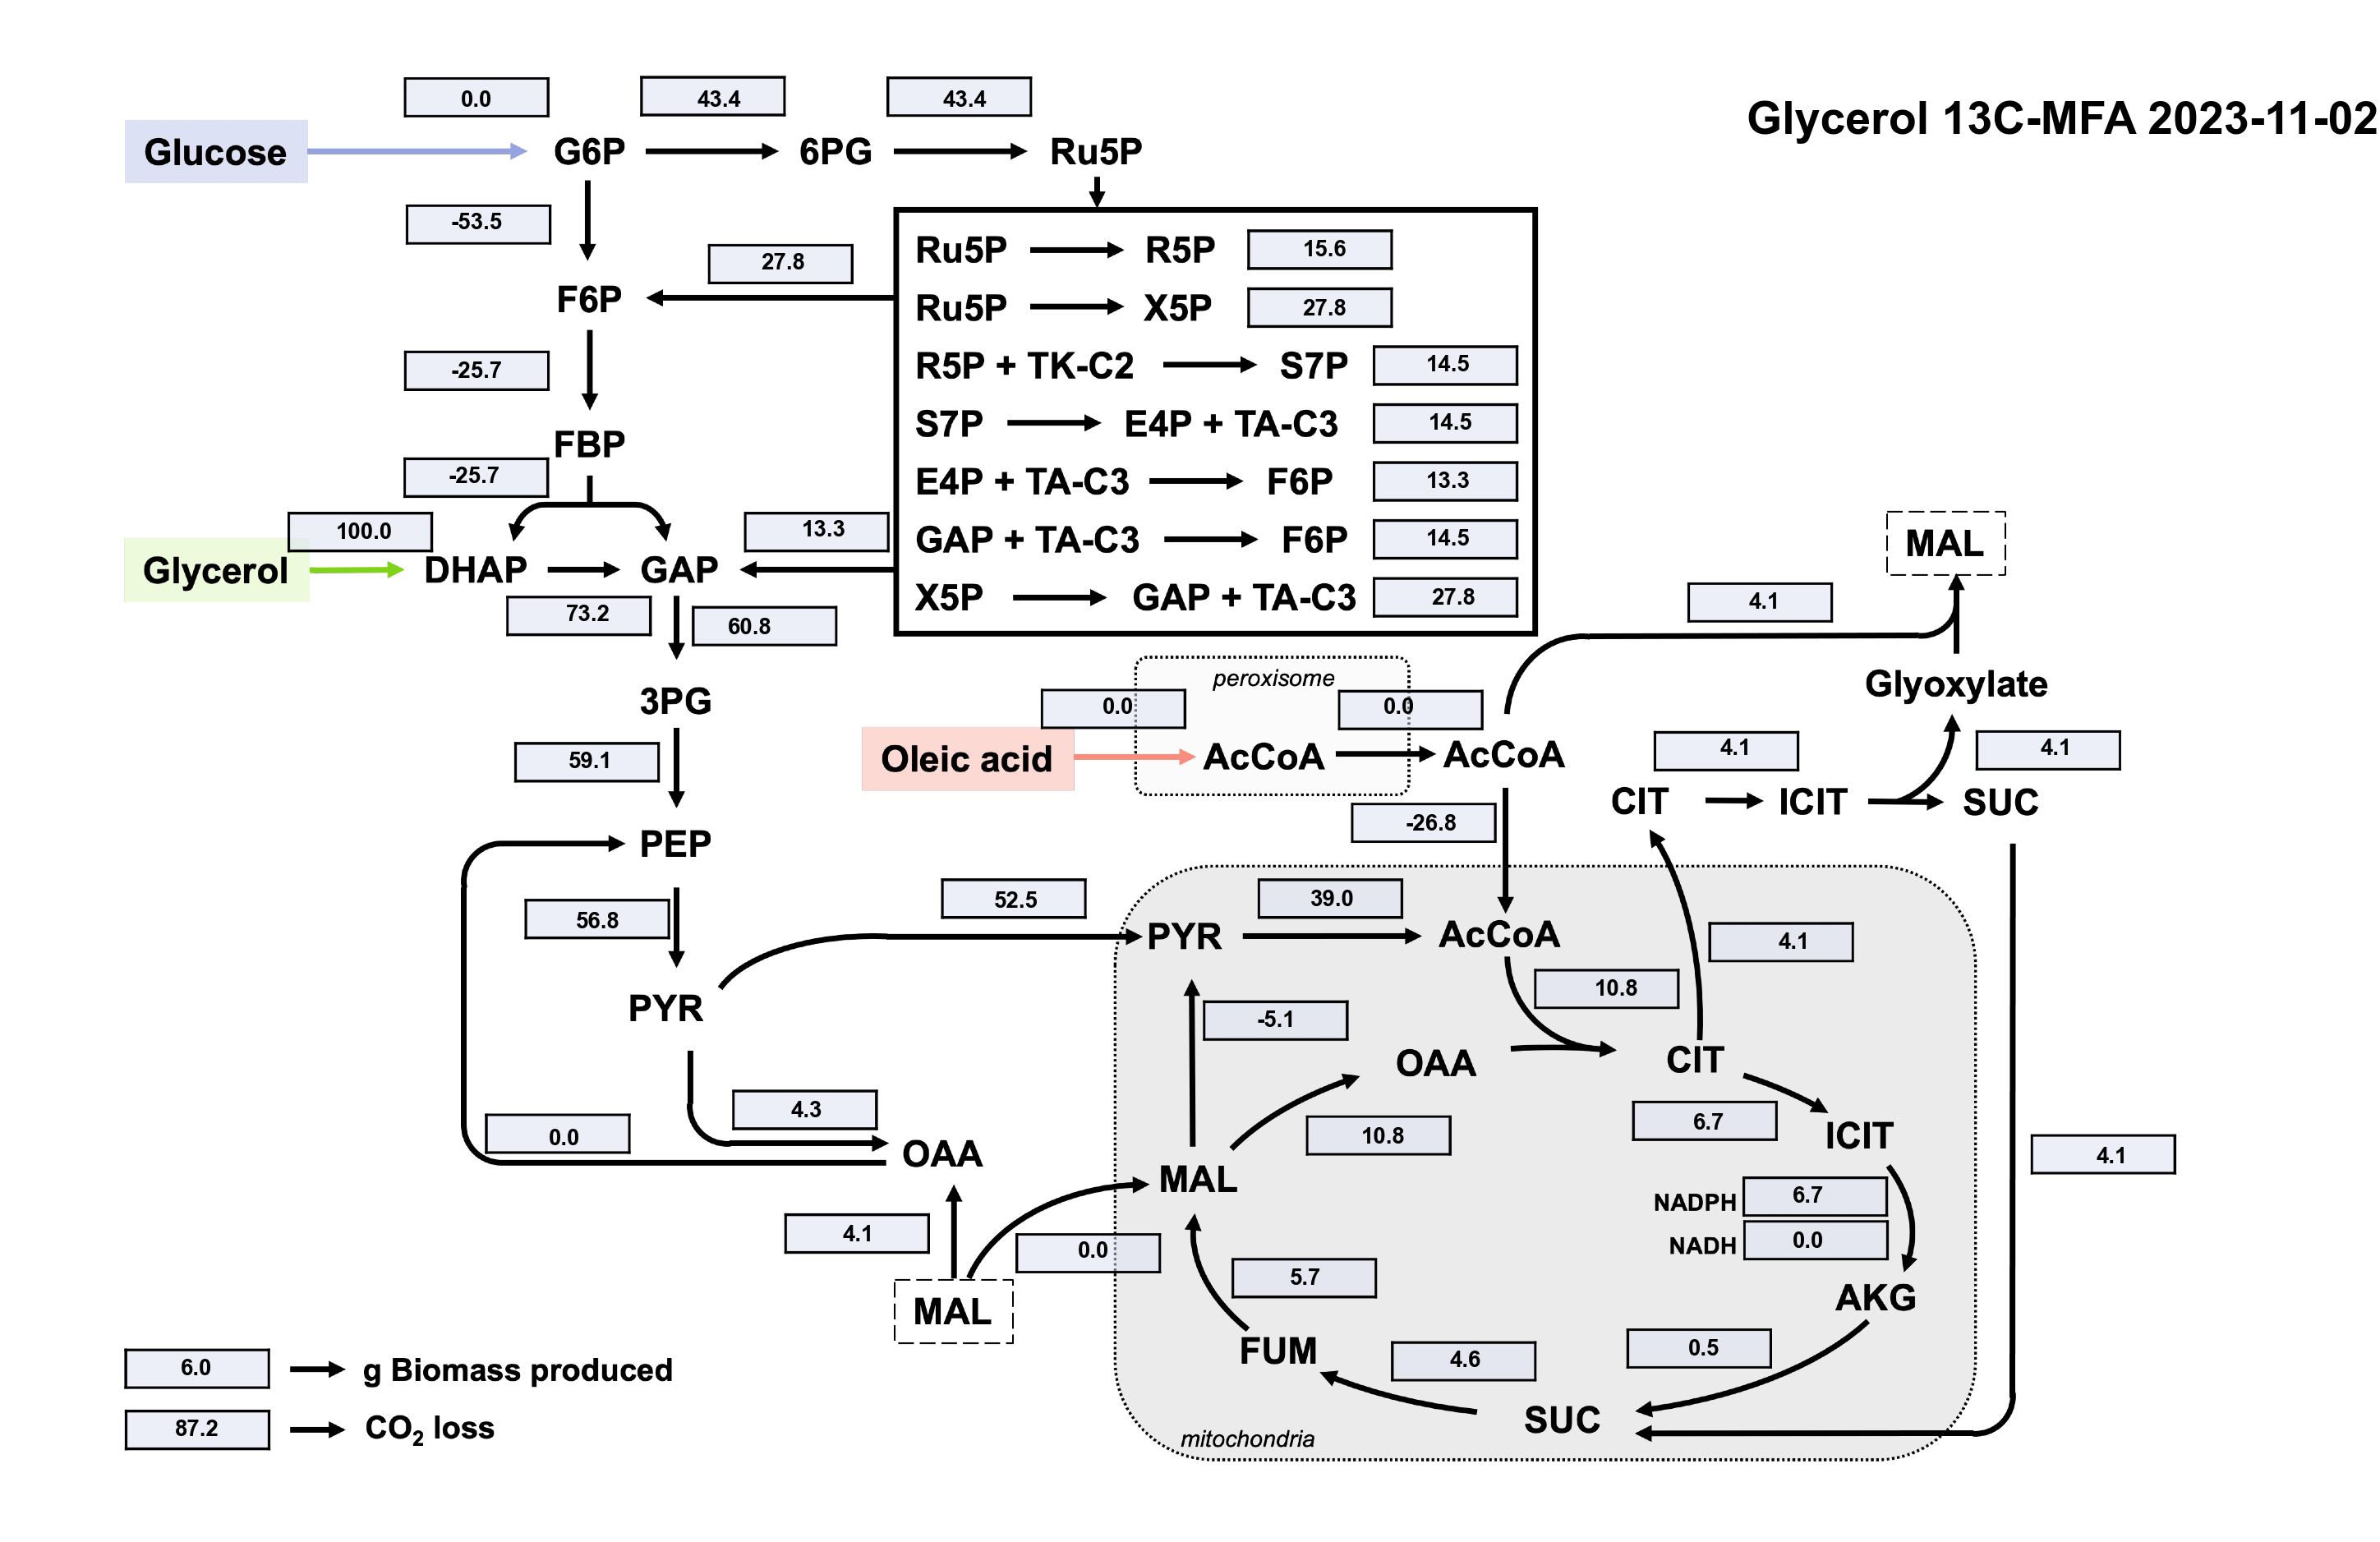

In [17]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column='glycerol_flux', 
    title_string='Glycerol 13C-MFA 2023-11-02',
    file_name='../figures/test_flux_map.png',
)

### Plot glycerol GSM flux

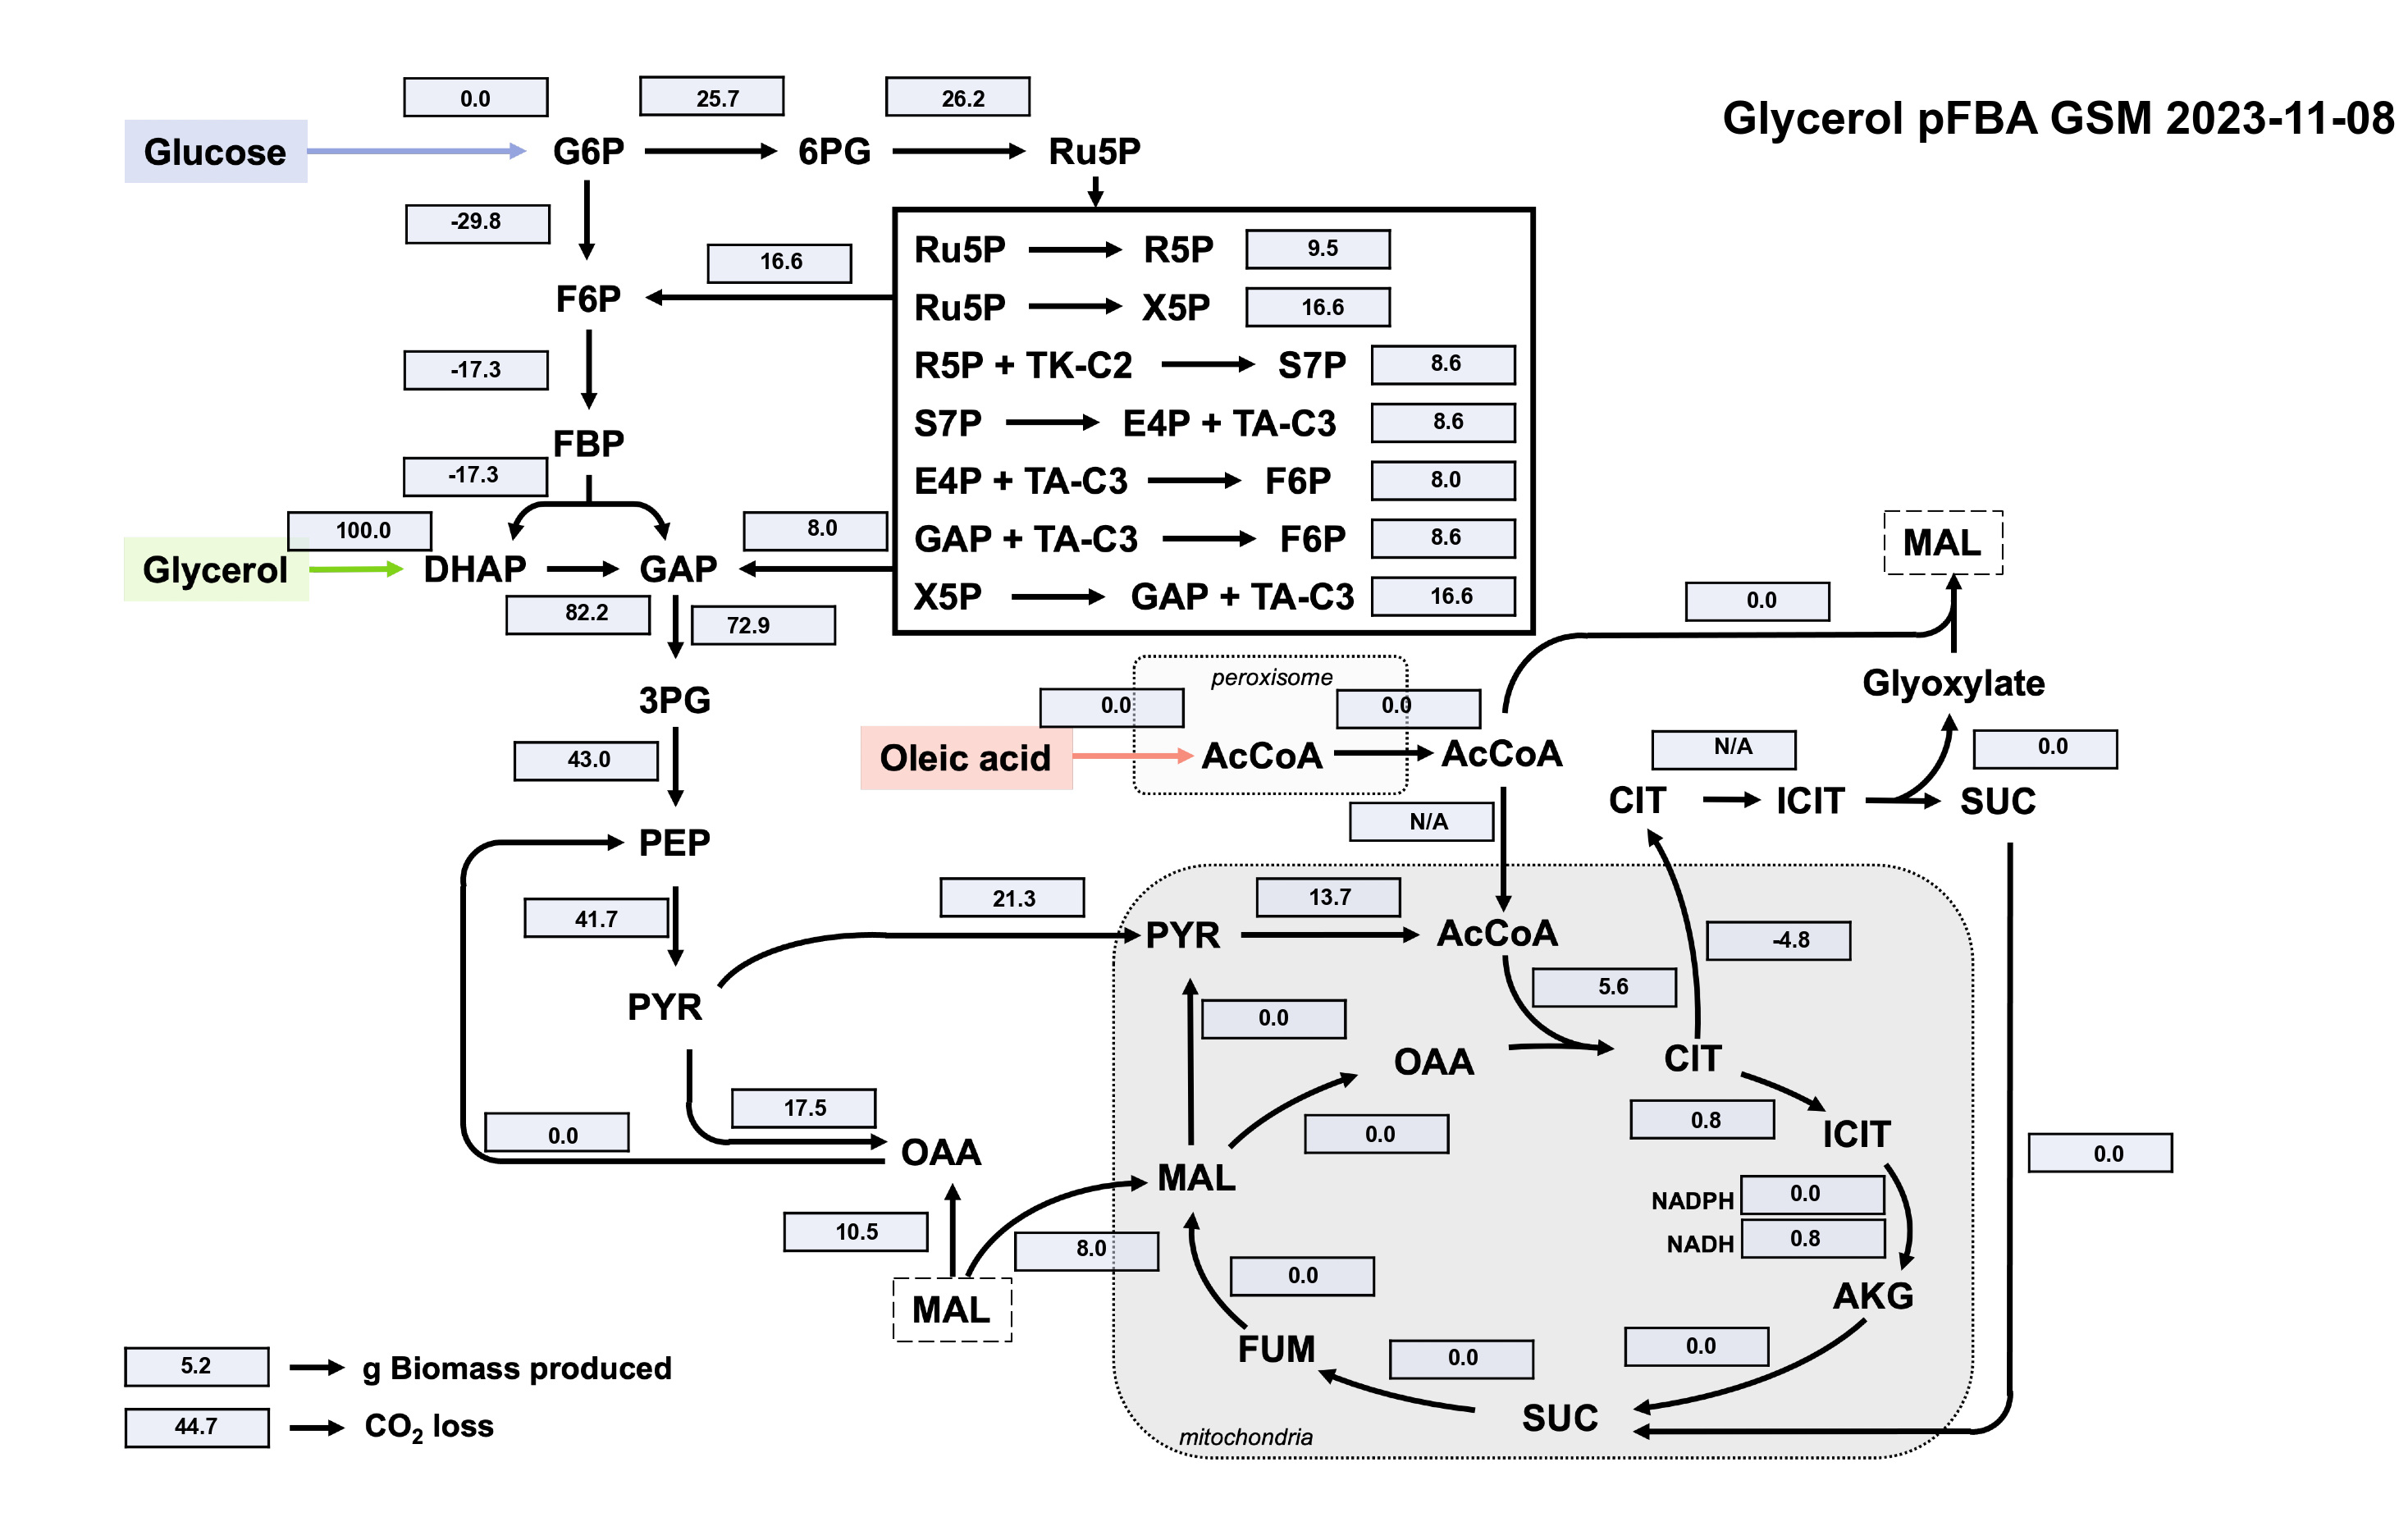

In [18]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column='glycerol_GSM_flux',
    title_string='Glycerol pFBA GSM 2023-11-08',
    file_name='../figures/test_flux_map.png',
)

### Plot glycerol MFA bounds

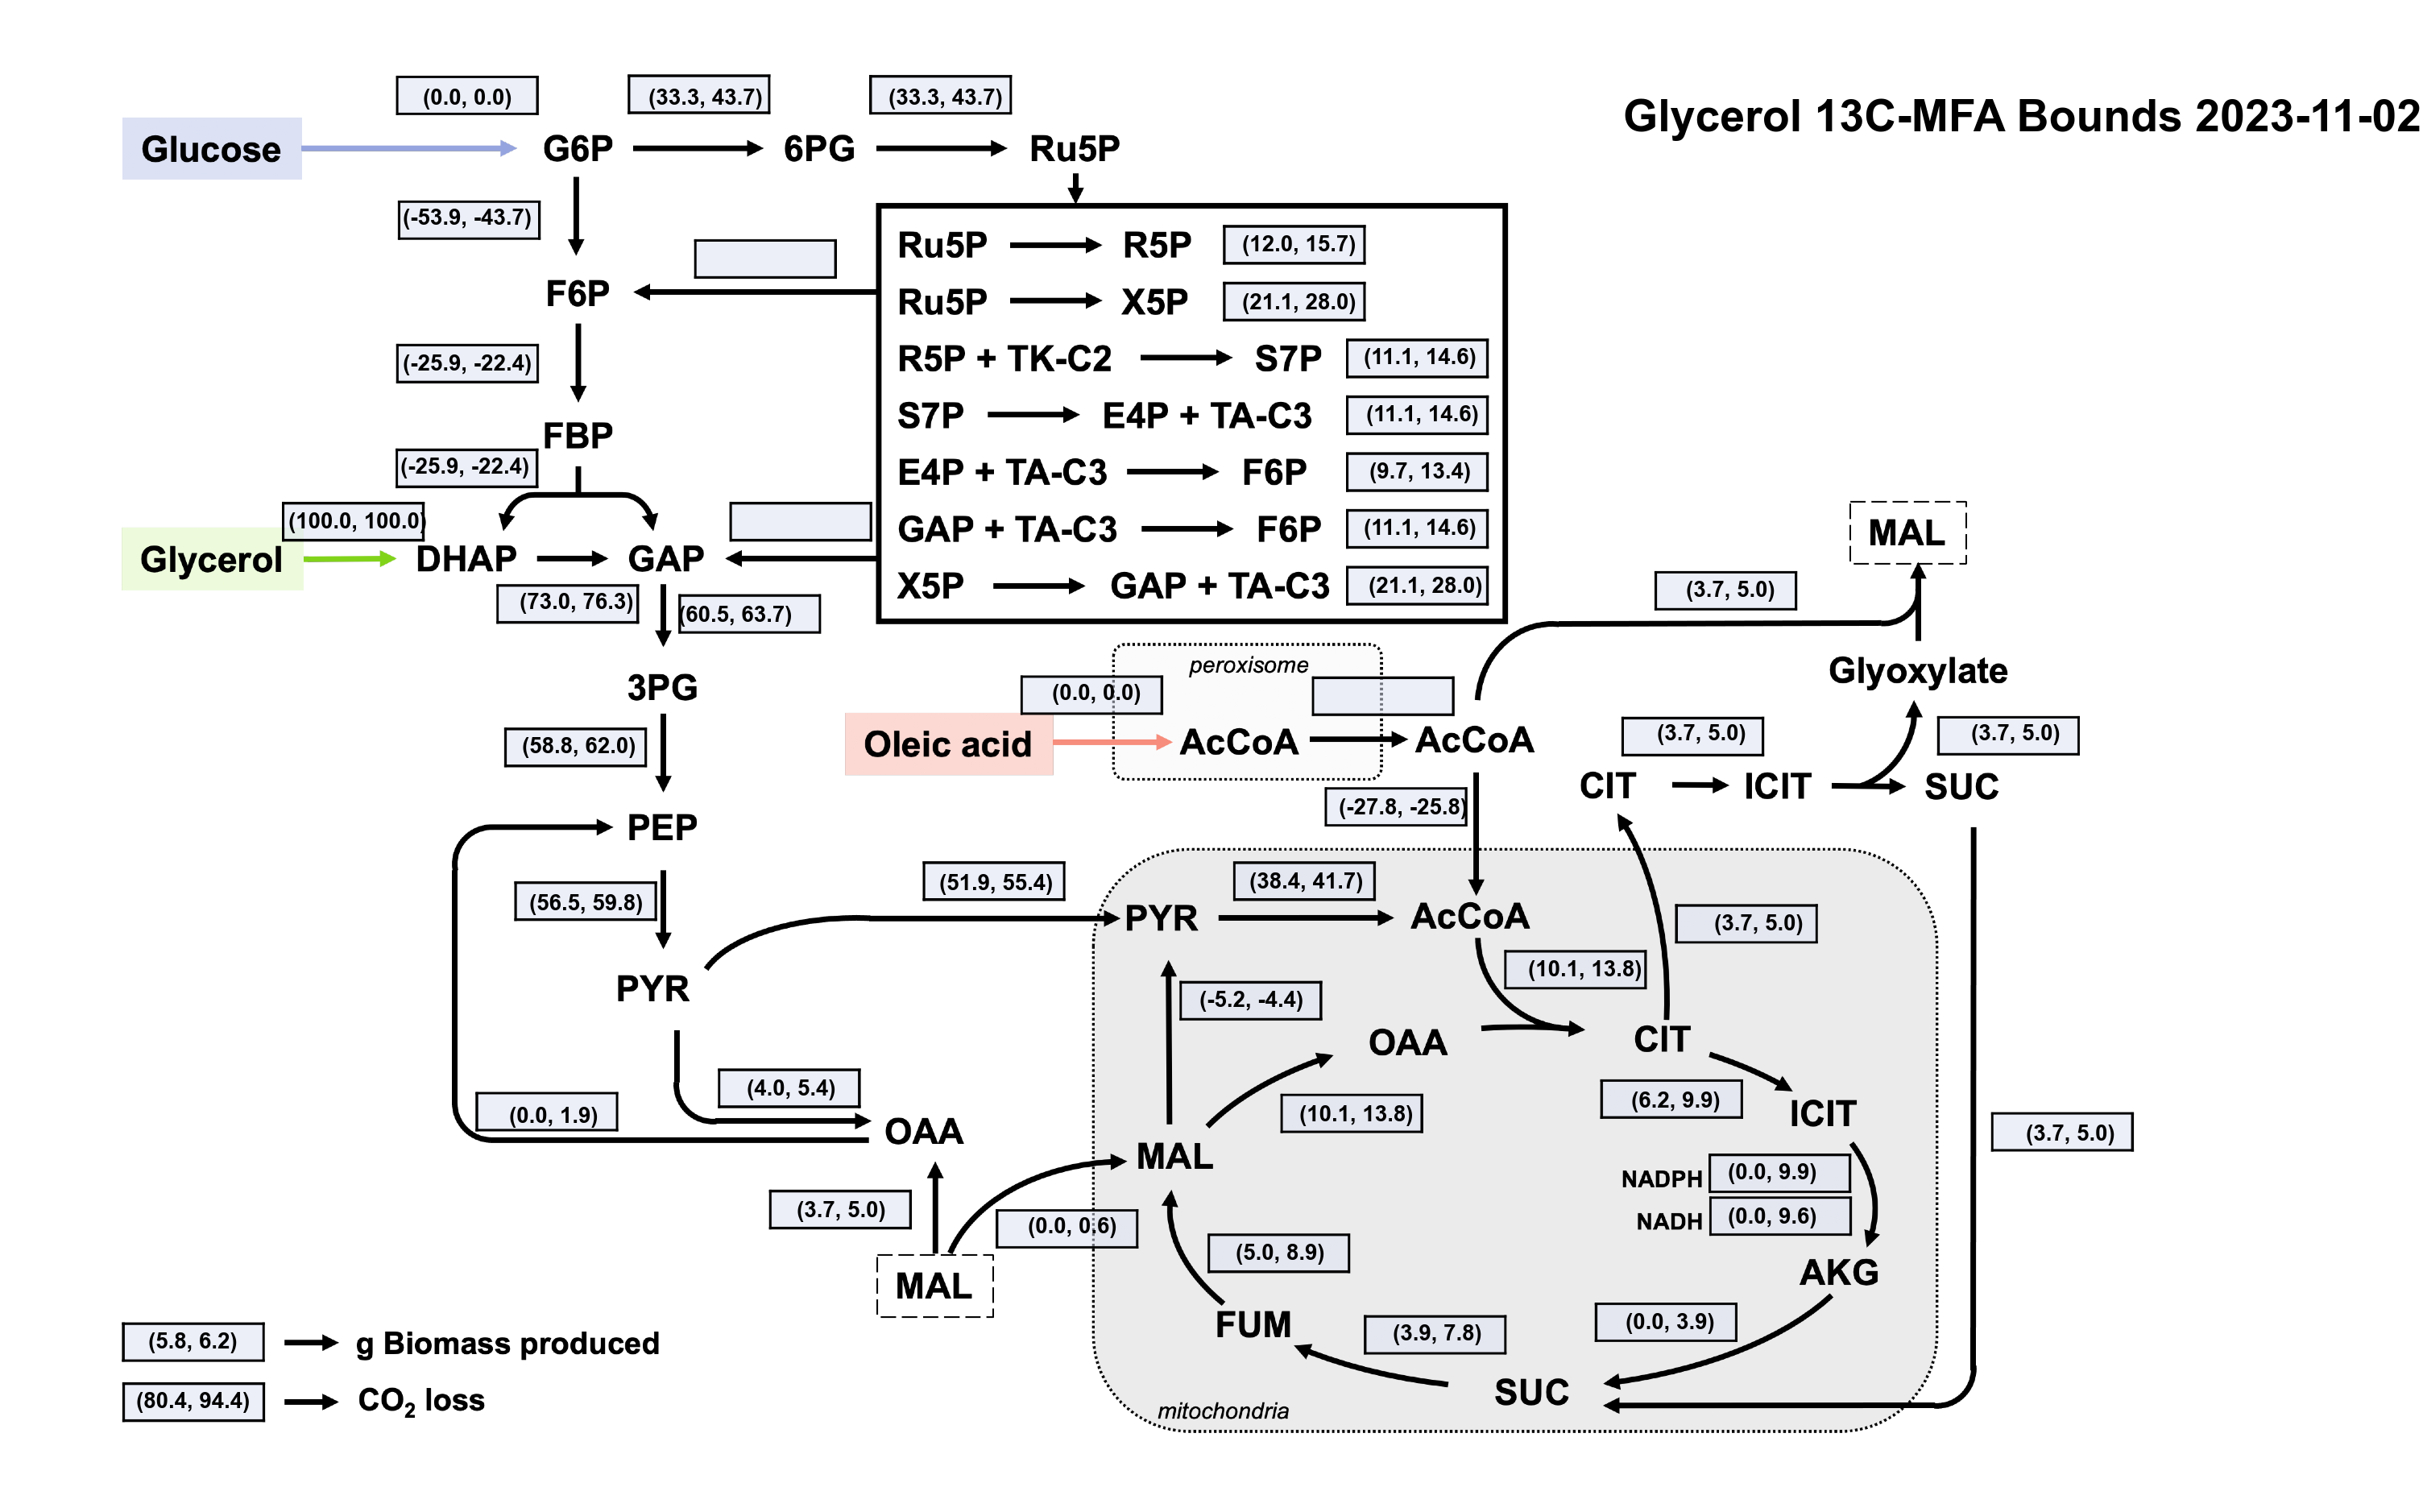

In [19]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column=['glycerol_LB', 'glycerol_UB'],
    title_string='Glycerol 13C-MFA Bounds 2023-11-02',
    file_name='../figures/test_flux_map.png',
)

### Plot glycerol GSM bounds

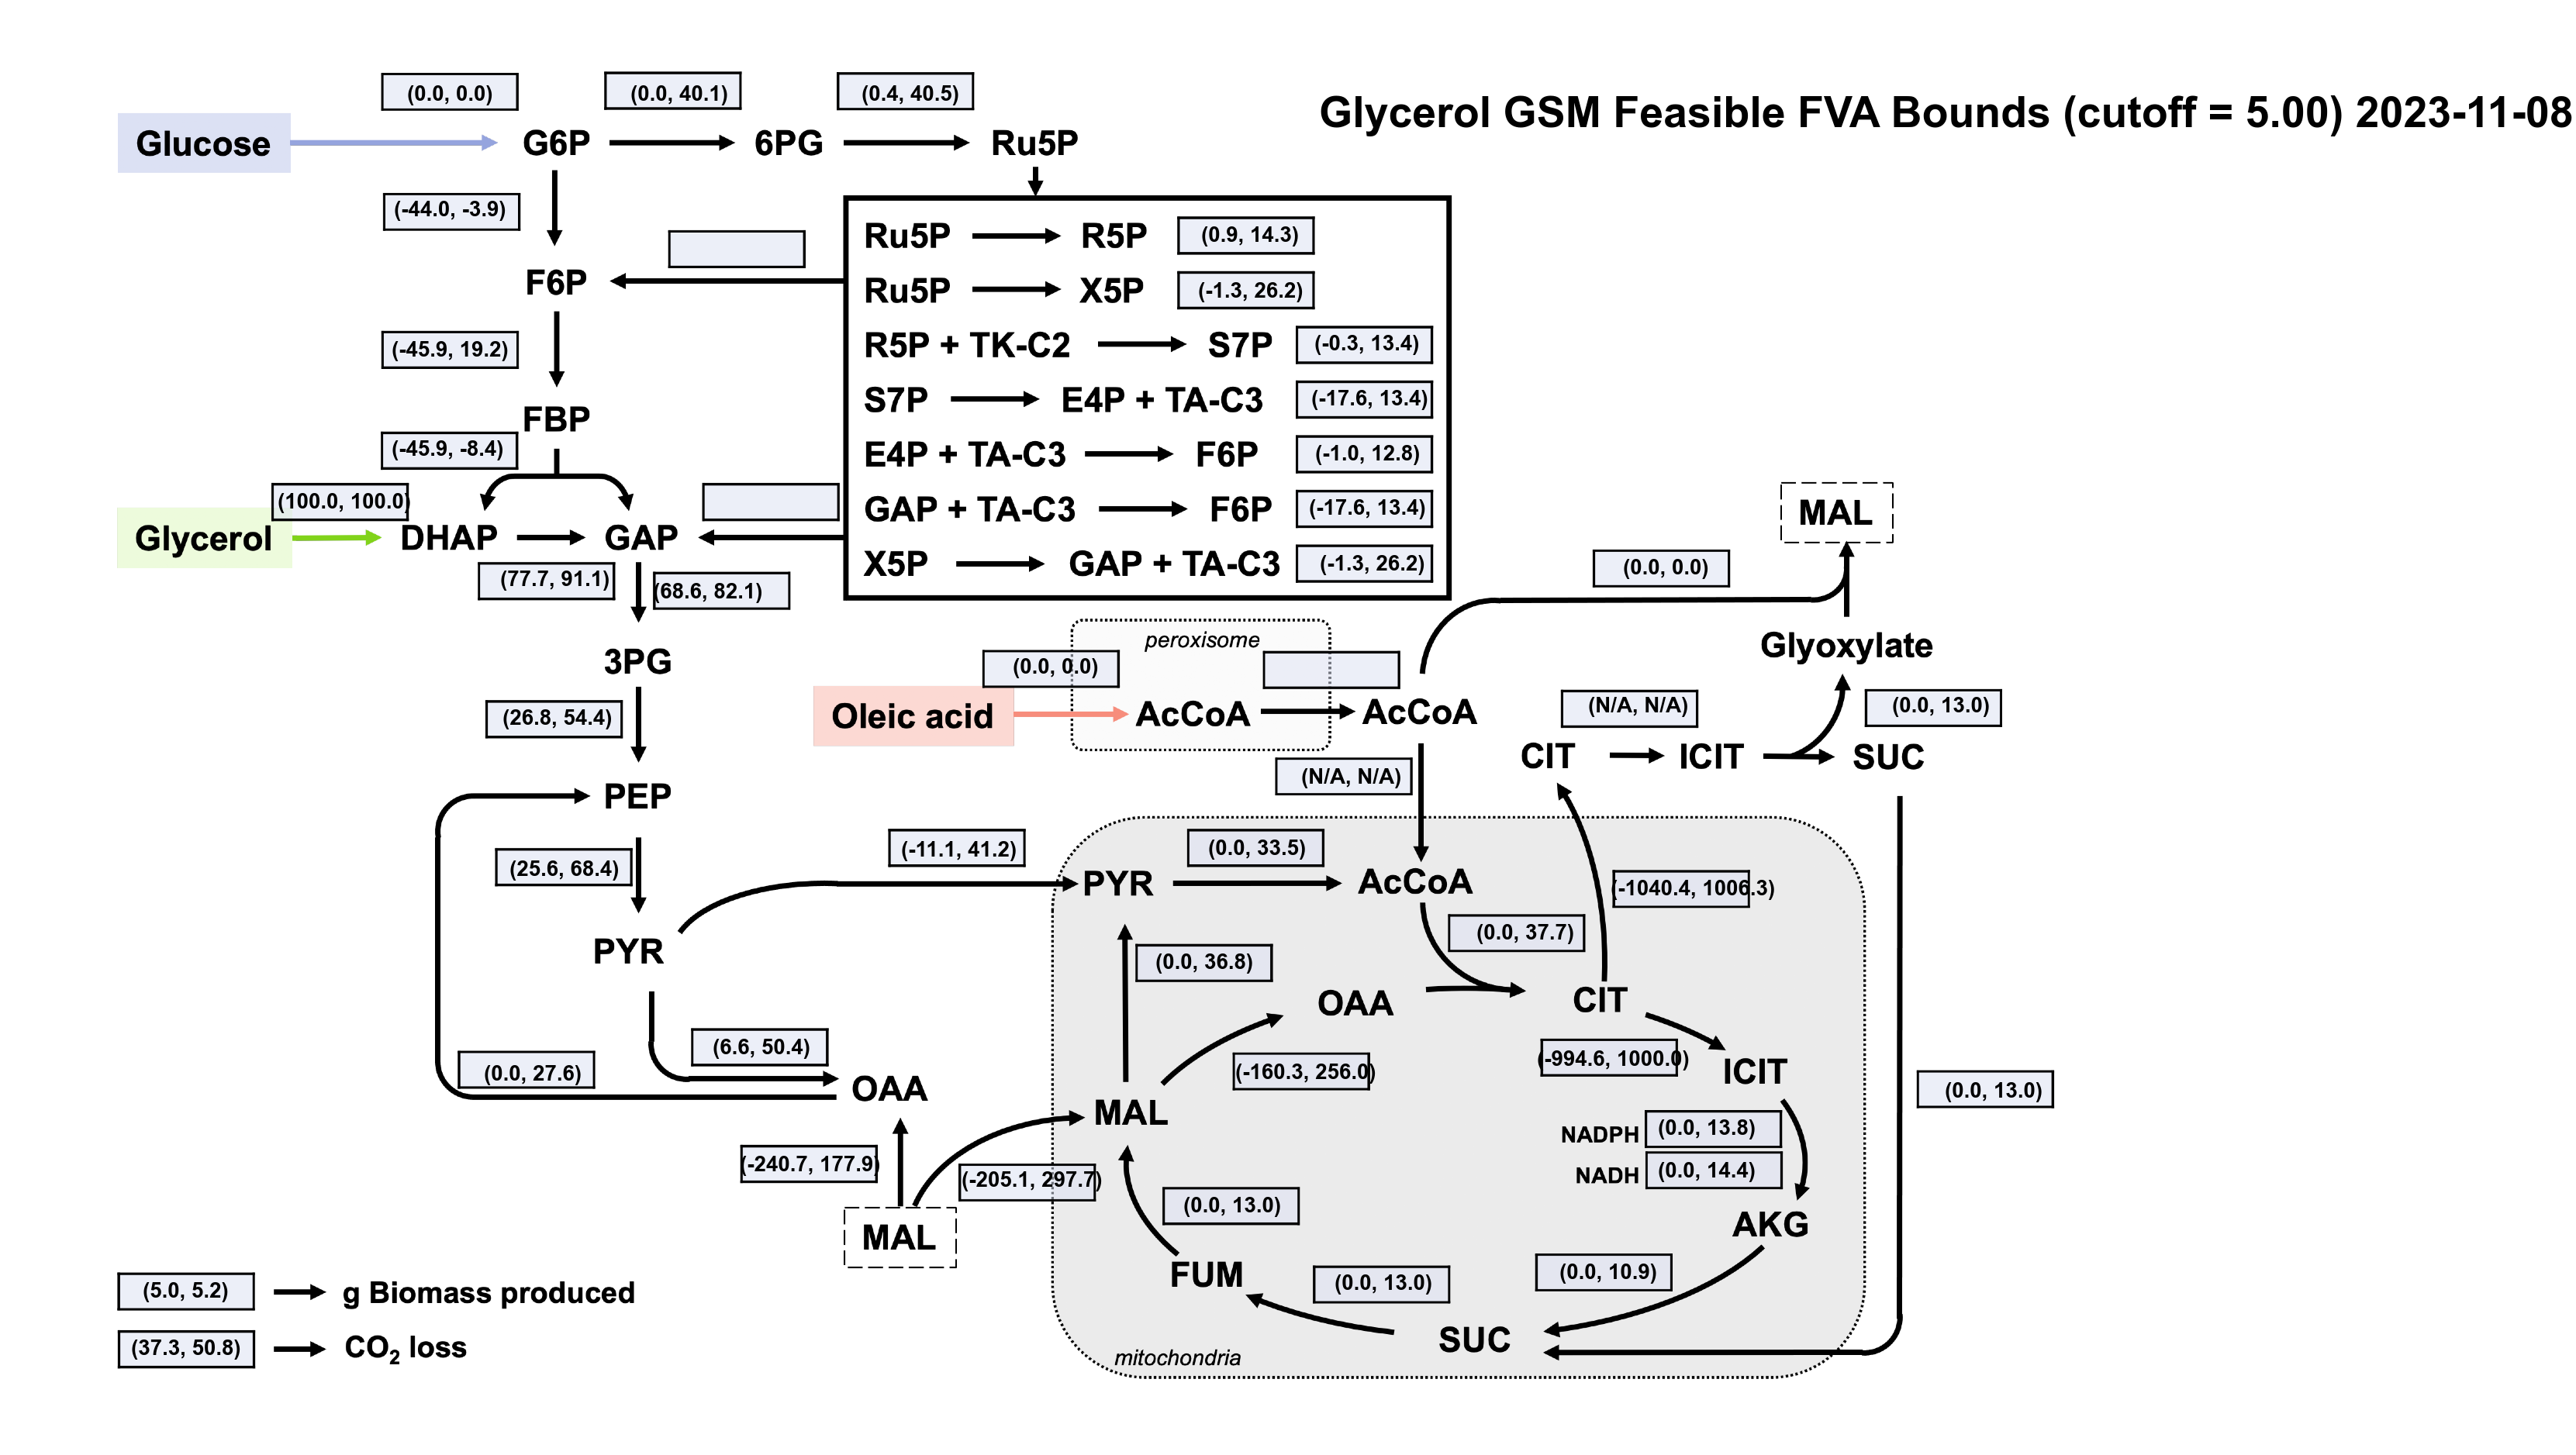

In [20]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column=['glycerol_GSM_LB', 'glycerol_GSM_UB'],
    title_string=f'Glycerol GSM Feasible FVA Bounds (cutoff = {biomass_cutoff:.2f}) 2023-11-08',
    file_name='../figures/test_flux_map.png',
)

# Oleic Acid

### Get yield coefficient

In [21]:
# Get oleic acid yield coefficient
oleic_acid_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'oleic_acid']
print(f'oleic acid yield coefficient: {oleic_acid_yield_coefficient} g biomass per mmol oleic_acid')


oleic acid yield coefficient: nan g biomass per mmol oleic_acid


### Run FVA with yield coefficient

In [22]:
biomass_cutoff = 100 * oleic_acid_yield_coefficient
biomass_cutoff = 25
oleic_acid_gsm_df = get_pfba_fva_df(
    model=model, 
    substrate='oleic_acid', 
    biomass_cutoff=biomass_cutoff
)
oleic_acid_gsm_df

Running pFBA FVA with the constraints: EX_ocdcea_e = -10, biomass_oil >= 2.5, biomass_glucose = 0, biomass_C = 0, biomass_N = 0:
ran pfba fva


reaction_id                                      reaction_name  \
0               13BGH                  Endo 1 3 beta glucan glucohydrase   
1              13BGHe                   Exo 1 3 beta glucan glucohydrase   
2               ASADi  aspartate semialdehyde dehydrogenase irreversible   
3            2DDA7Ptm  2 Dehydro 3 deoxy D arabino heptonate7 phohsph...   
4              2DHPtm          2 Dehydropantoate mitochondrial transport   
...               ...                                                ...   
1345      erythritolT                                        erythritolT   
1346      EX_eryth(e)                                        EX_eryth(e)   
1347          EX_biom                                            EX_biom   
1348  biomass_glucose                                                      
1349      biomass_oil                                                      

                                          full_reaction  oleic_acid_GSM_flux  \
0                     13BDglcn[c] + h2o[c] --> glc_D[c]             0.000000   
1                     13BDglcn[e] + h2o[e] --> glc_D[e]             0.000000   
2     4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...             6.128174   
3                               2dda7p[c] <=> 2dda7p[m]             0.000000   
4                                   2dhp[c] <=> 2dhp[m]             0.000000   
...                                                 ...                  ...   
1345                    erythritol[c] <=> erythritol[e]             0.000000   
1346                                 erythritol[e] -->              0.000000   
1347                                    biomass[c] -->             30.541497   
1348  0.6822317267700153 13BDglcn[c] + 0.55815800338...             0.000000   
1349  0.6822317267700153 13BDglcn[c] + 0.32998465303...            30.541497   

      oleic_acid_GSM_LB  oleic_acid_GSM_UB  
0              0.000000         545.107376  
1              0.000000          -0.000000  
2              5.016269         176.368131  
3            -54.774410          -0.000000  
4              0.000000          23.778396  
...                 ...                ...  
1345           0.000000          55.891487  
1346           0.000000          55.891487  
1347          25.000000          30.541497  
1348           0.000000          -0.000000  
1349          25.000000          30.541497  

[1350 rows x 6 columns]

### Add oleic acid FVA data to the central pathway dataframe

In [23]:
# add pfba flux column
full_central_rxn_df = add_flux_column_to_13c_flux_df(full_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_GSM_flux')
full_central_rxn_df = add_fva_columns_to_13c_flux_df(full_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_GSM_LB', 'oleic_acid_GSM_UB')
full_central_rxn_df = add_mfa_bound_feasibility_column(full_central_rxn_df, 'oleic_acid')

full_central_rxn_df

Unnamed: 0           ID  \
0                      uptake       uptake   
1                      uptake    R3 glyc3p   
2                      uptake  R3 dhap net   
3                      uptake    OA uptake   
4   glycolysis/gluconeogensis       R4 net   
..                        ...          ...   
66          biomass formation          R80   
67          energy metabolism          R81   
68          energy metabolism          R82   
69          energy metabolism          R83   
70              co2_formation          R79   

                                     Equation  \
0                        Glucose + ATP -> G6P   
1                        GLYC + ATP -> Glyc3P   
2                      Glyc3P <-> DHAP + UQH2   
3   OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2   
4                                 G6P <-> F6P   
..                                        ...   
66                                        NaN   
67                     ATP -> ATP_maintenance   
68                              NADH -> NADPH   
69                              NADH -> 2*ATP   
70                              CO2 -> CO2_EX   

                                   reaction_ids            pathway  \
0                              reverse_EX_glc_e   substrate_uptake   
1                                 reverse_GLYCt                emp   
2                                           NaN                emp   
3                                       OCDCEAt   substrate_uptake   
4                                           PGI                emp   
..                                          ...                ...   
66  biomass_C or biomass_glucose or biomass_oil  biomass_formation   
67                                         ATPM  energy_metabolism   
68                                          NaN                NaN   
69                                          NaN                NaN   
70                                 reverse_CO2t          transport   

      compartment Location on map  glucose_flux  glucose_std_err  glucose_LB  \
0         cytosol   (-1180, 1175)      100.0000        3658.8000    100.0000   
1         cytosol    (-1376, 417)           NaN              NaN         NaN   
2         cytosol             NaN           NaN              NaN         NaN   
3         cytosol      (-55, 111)           NaN              NaN         NaN   
4         cytosol    (-1180, 960)       19.0701         698.0030      9.1106   
..            ...             ...           ...              ...         ...   
66        cytosol  (-1670, -1049)       11.2586         411.9407      9.8463   
67        cytosol             NaN      613.4628       22445.0000    436.2967   
68            NaN             NaN       33.5917       27366.0000      0.0000   
69            NaN             NaN      280.3469       10257.0000    210.3067   
70  extracellular  (-1670, -1155)      198.2584        7253.6000    161.2777   

    ...  glucose_GSM_UB  glucose_mfa_bound_feasibility  glycerol_GSM_flux  \
0   ...           100.0                 fully feasible                0.0   
1   ...             0.0                                             100.0   
2   ...                                                                     
3   ...             0.0                                               0.0   
4   ...       91.399332                 fully feasible         -29.786348   
..  ...             ...                            ...                ...   
66  ...       12.749805             partially feasible           5.189712   
67  ...      228.875572                   not feasible                0.0   
68  ...                                                                     
69  ...                                                                     
70  ...      239.003551             partially feasible          44.670111   

    glycerol_GSM_LB  glycerol_GSM_UB  glycerol_mfa_bound_feasibility  \
0               0.0              0.0                                   
1     

### Plot oleic acid MFA flux

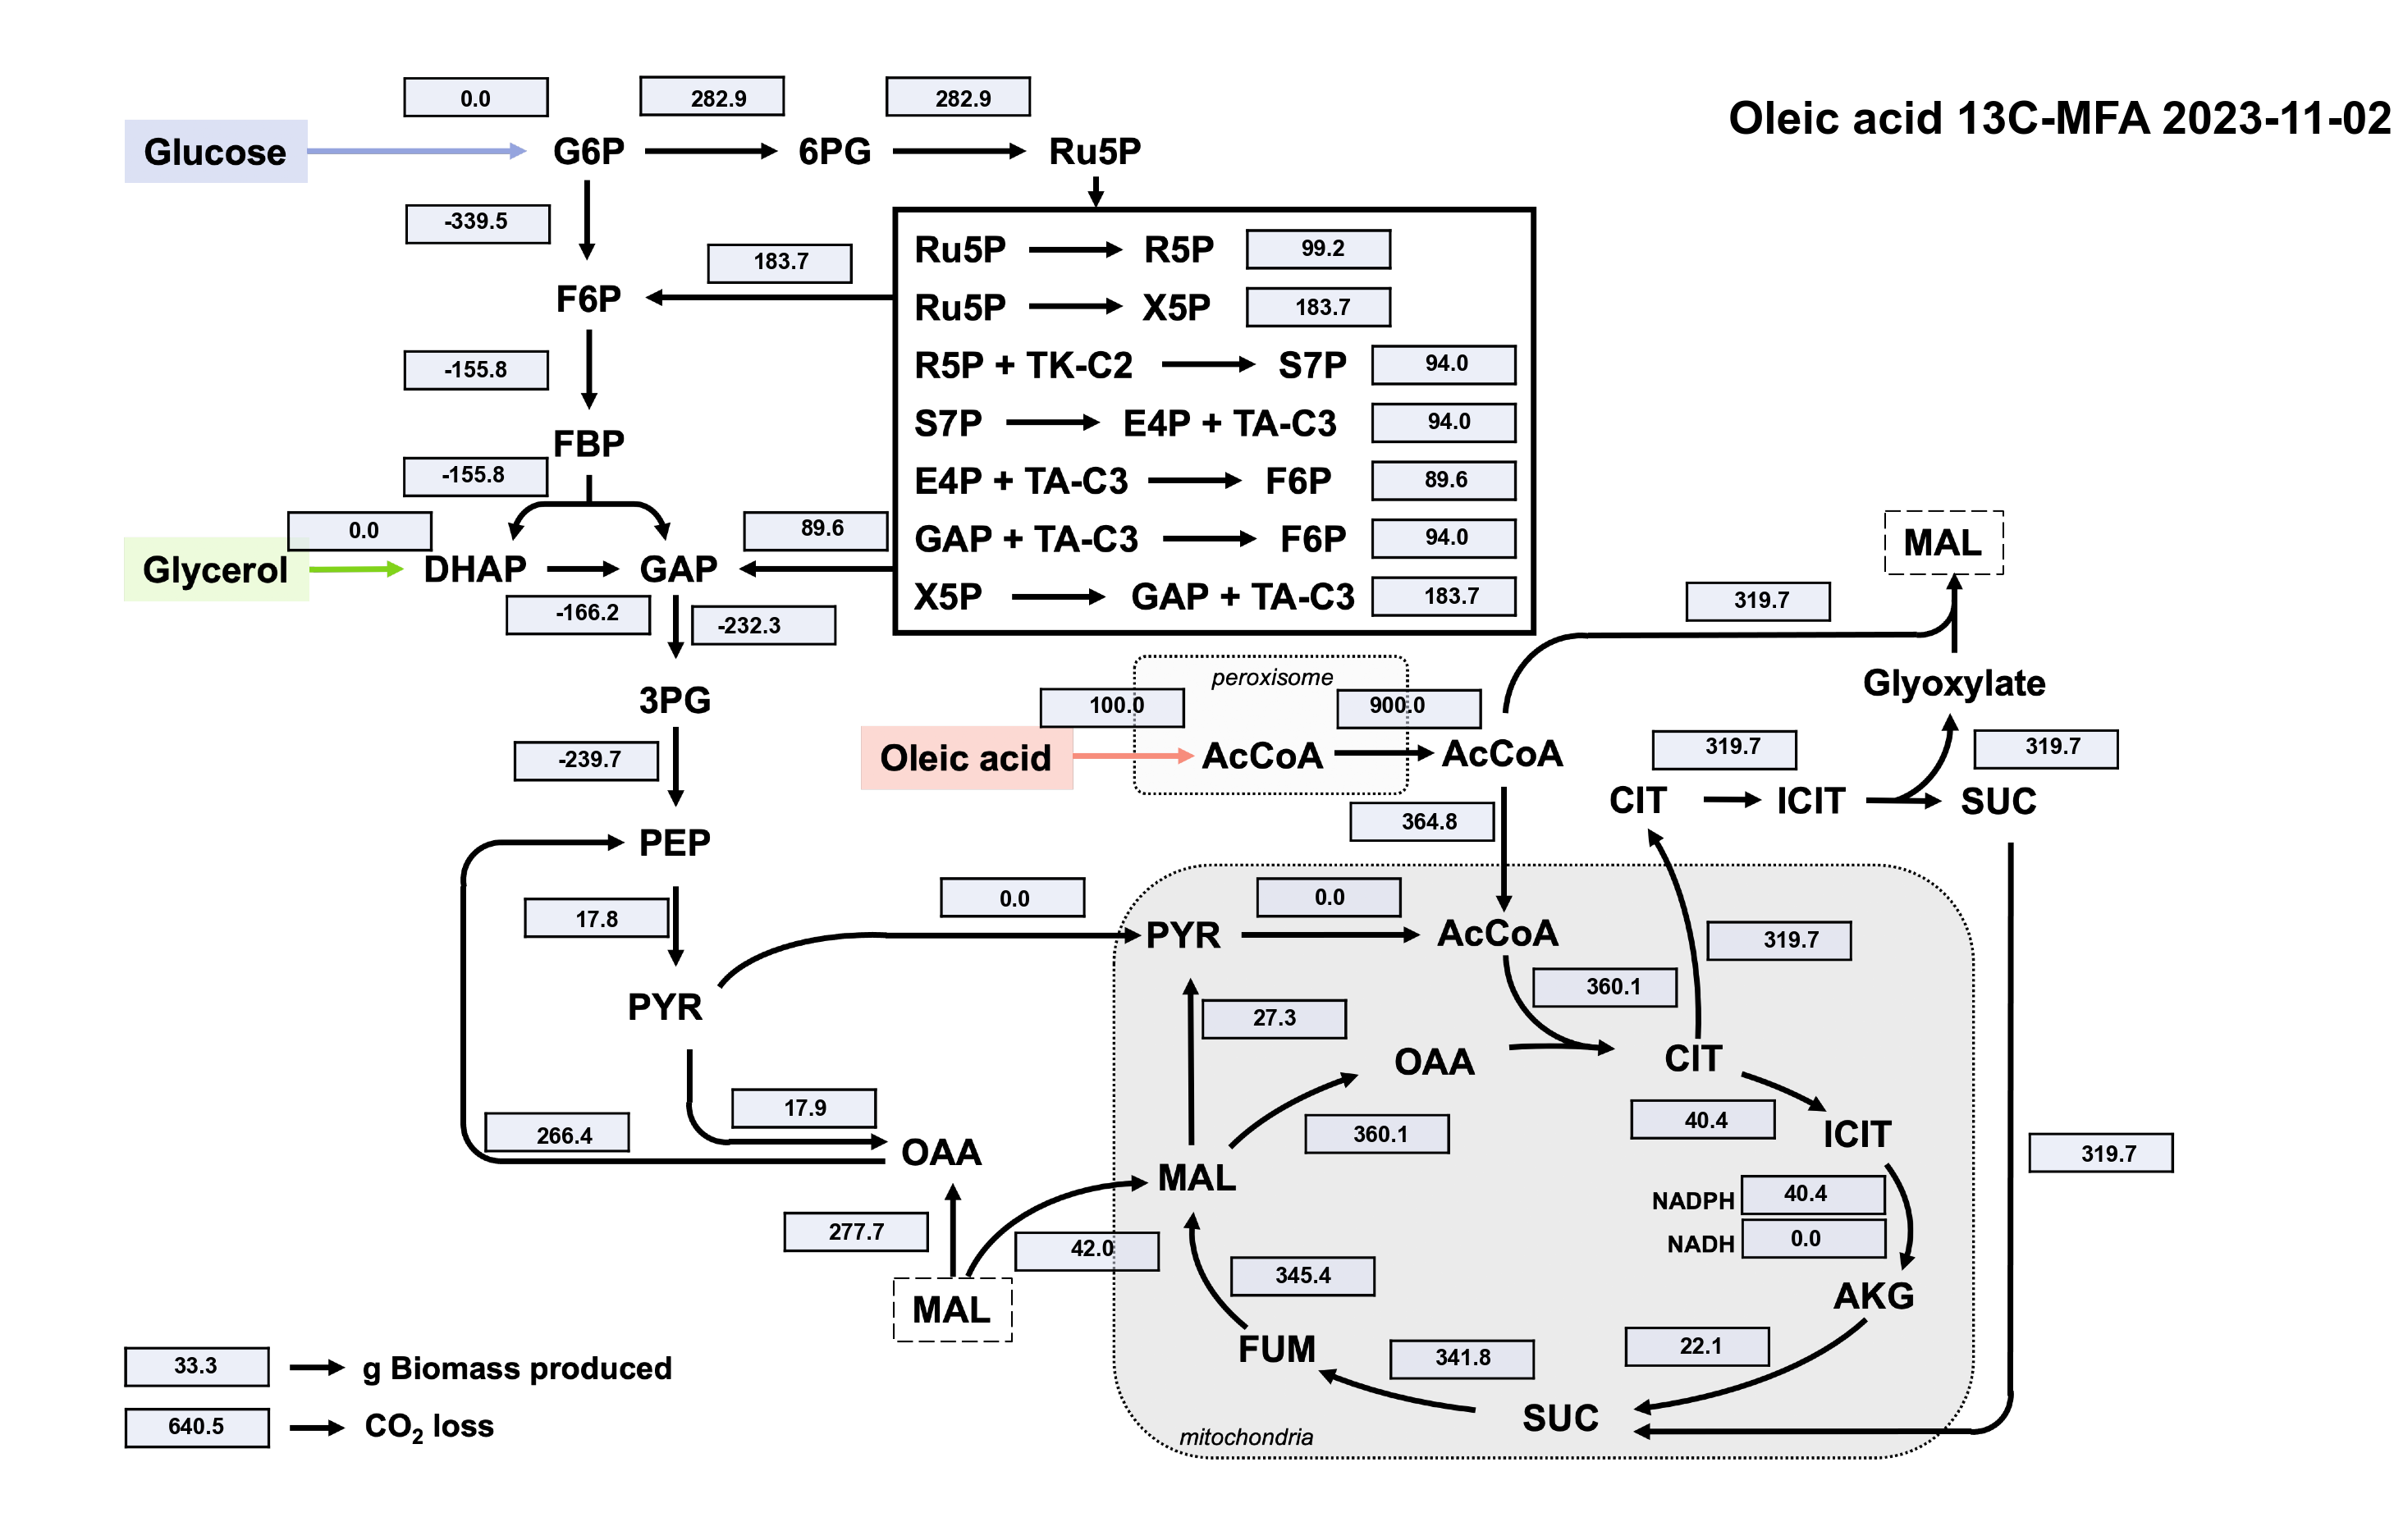

In [24]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column='oleic_acid_flux', 
    title_string='Oleic acid 13C-MFA 2023-11-02',
    file_name='../figures/test_flux_map.png',
)

### Plot Oleic Acid pFBA

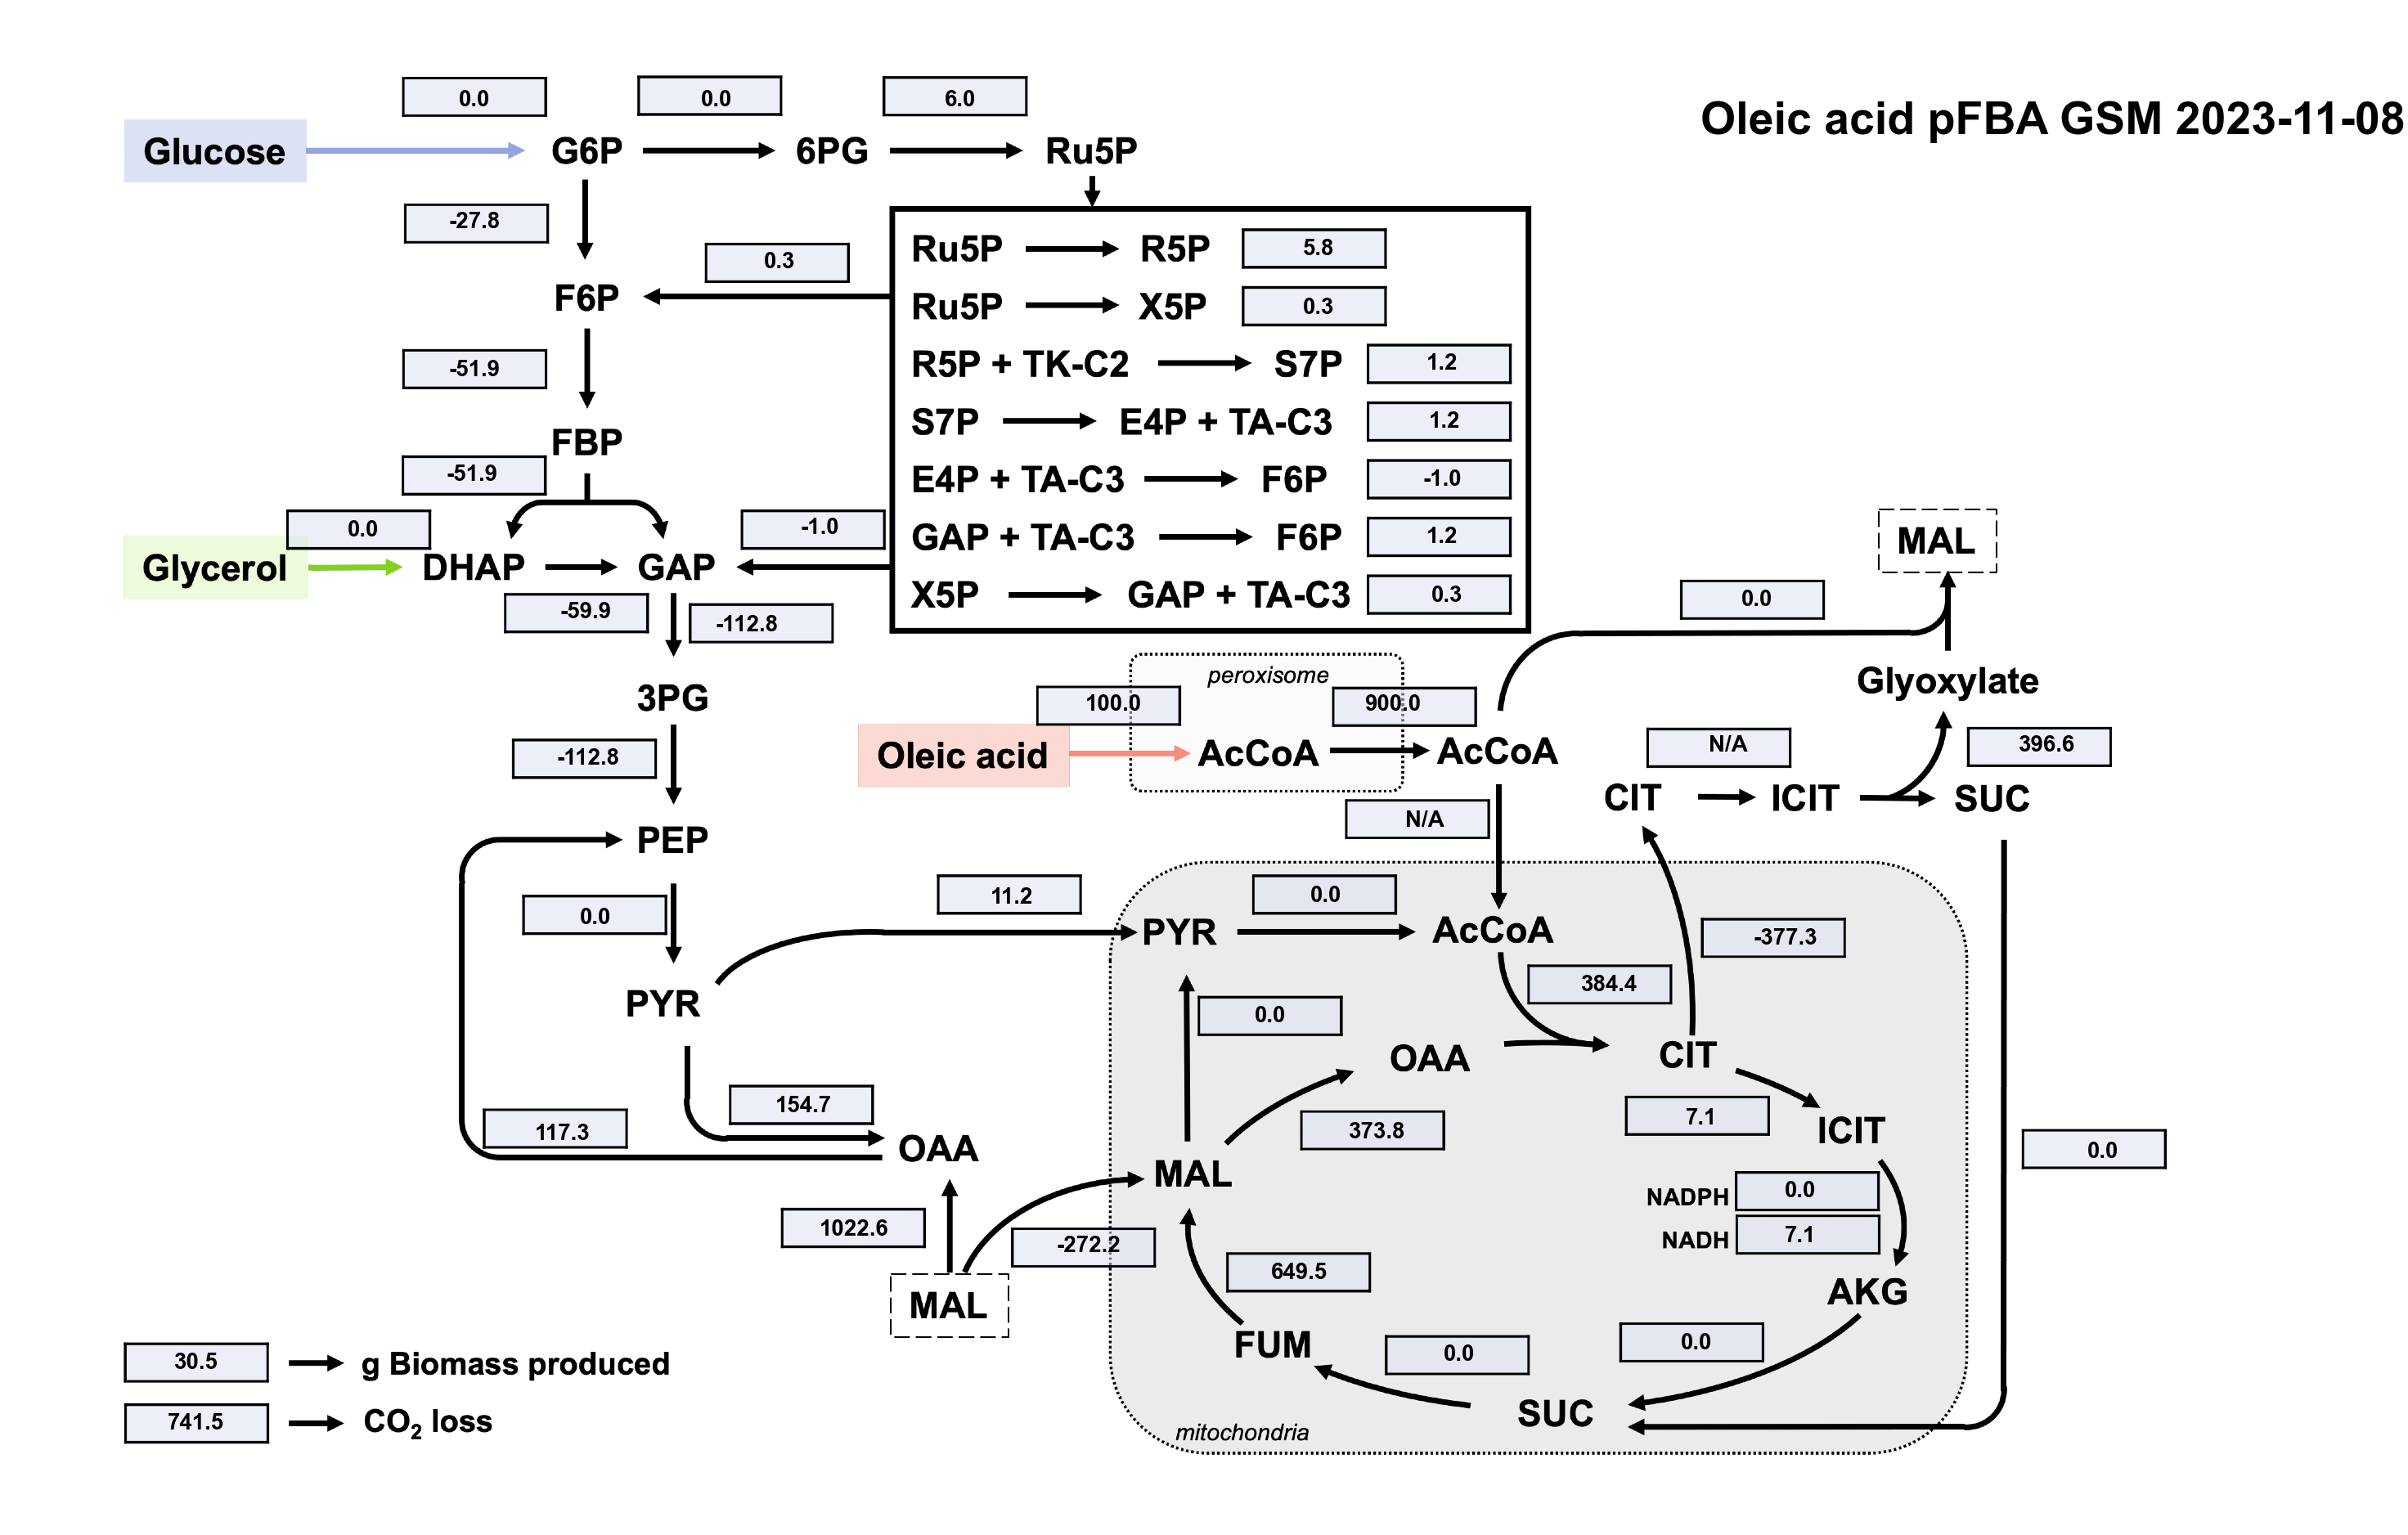

In [25]:
# Plot Oleic Acid pFBA
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column='oleic_acid_GSM_flux', 
    title_string='Oleic acid pFBA GSM 2023-11-08',
    file_name='../figures/test_flux_map.png',
)

### Plot oleic acid MFA Bounds

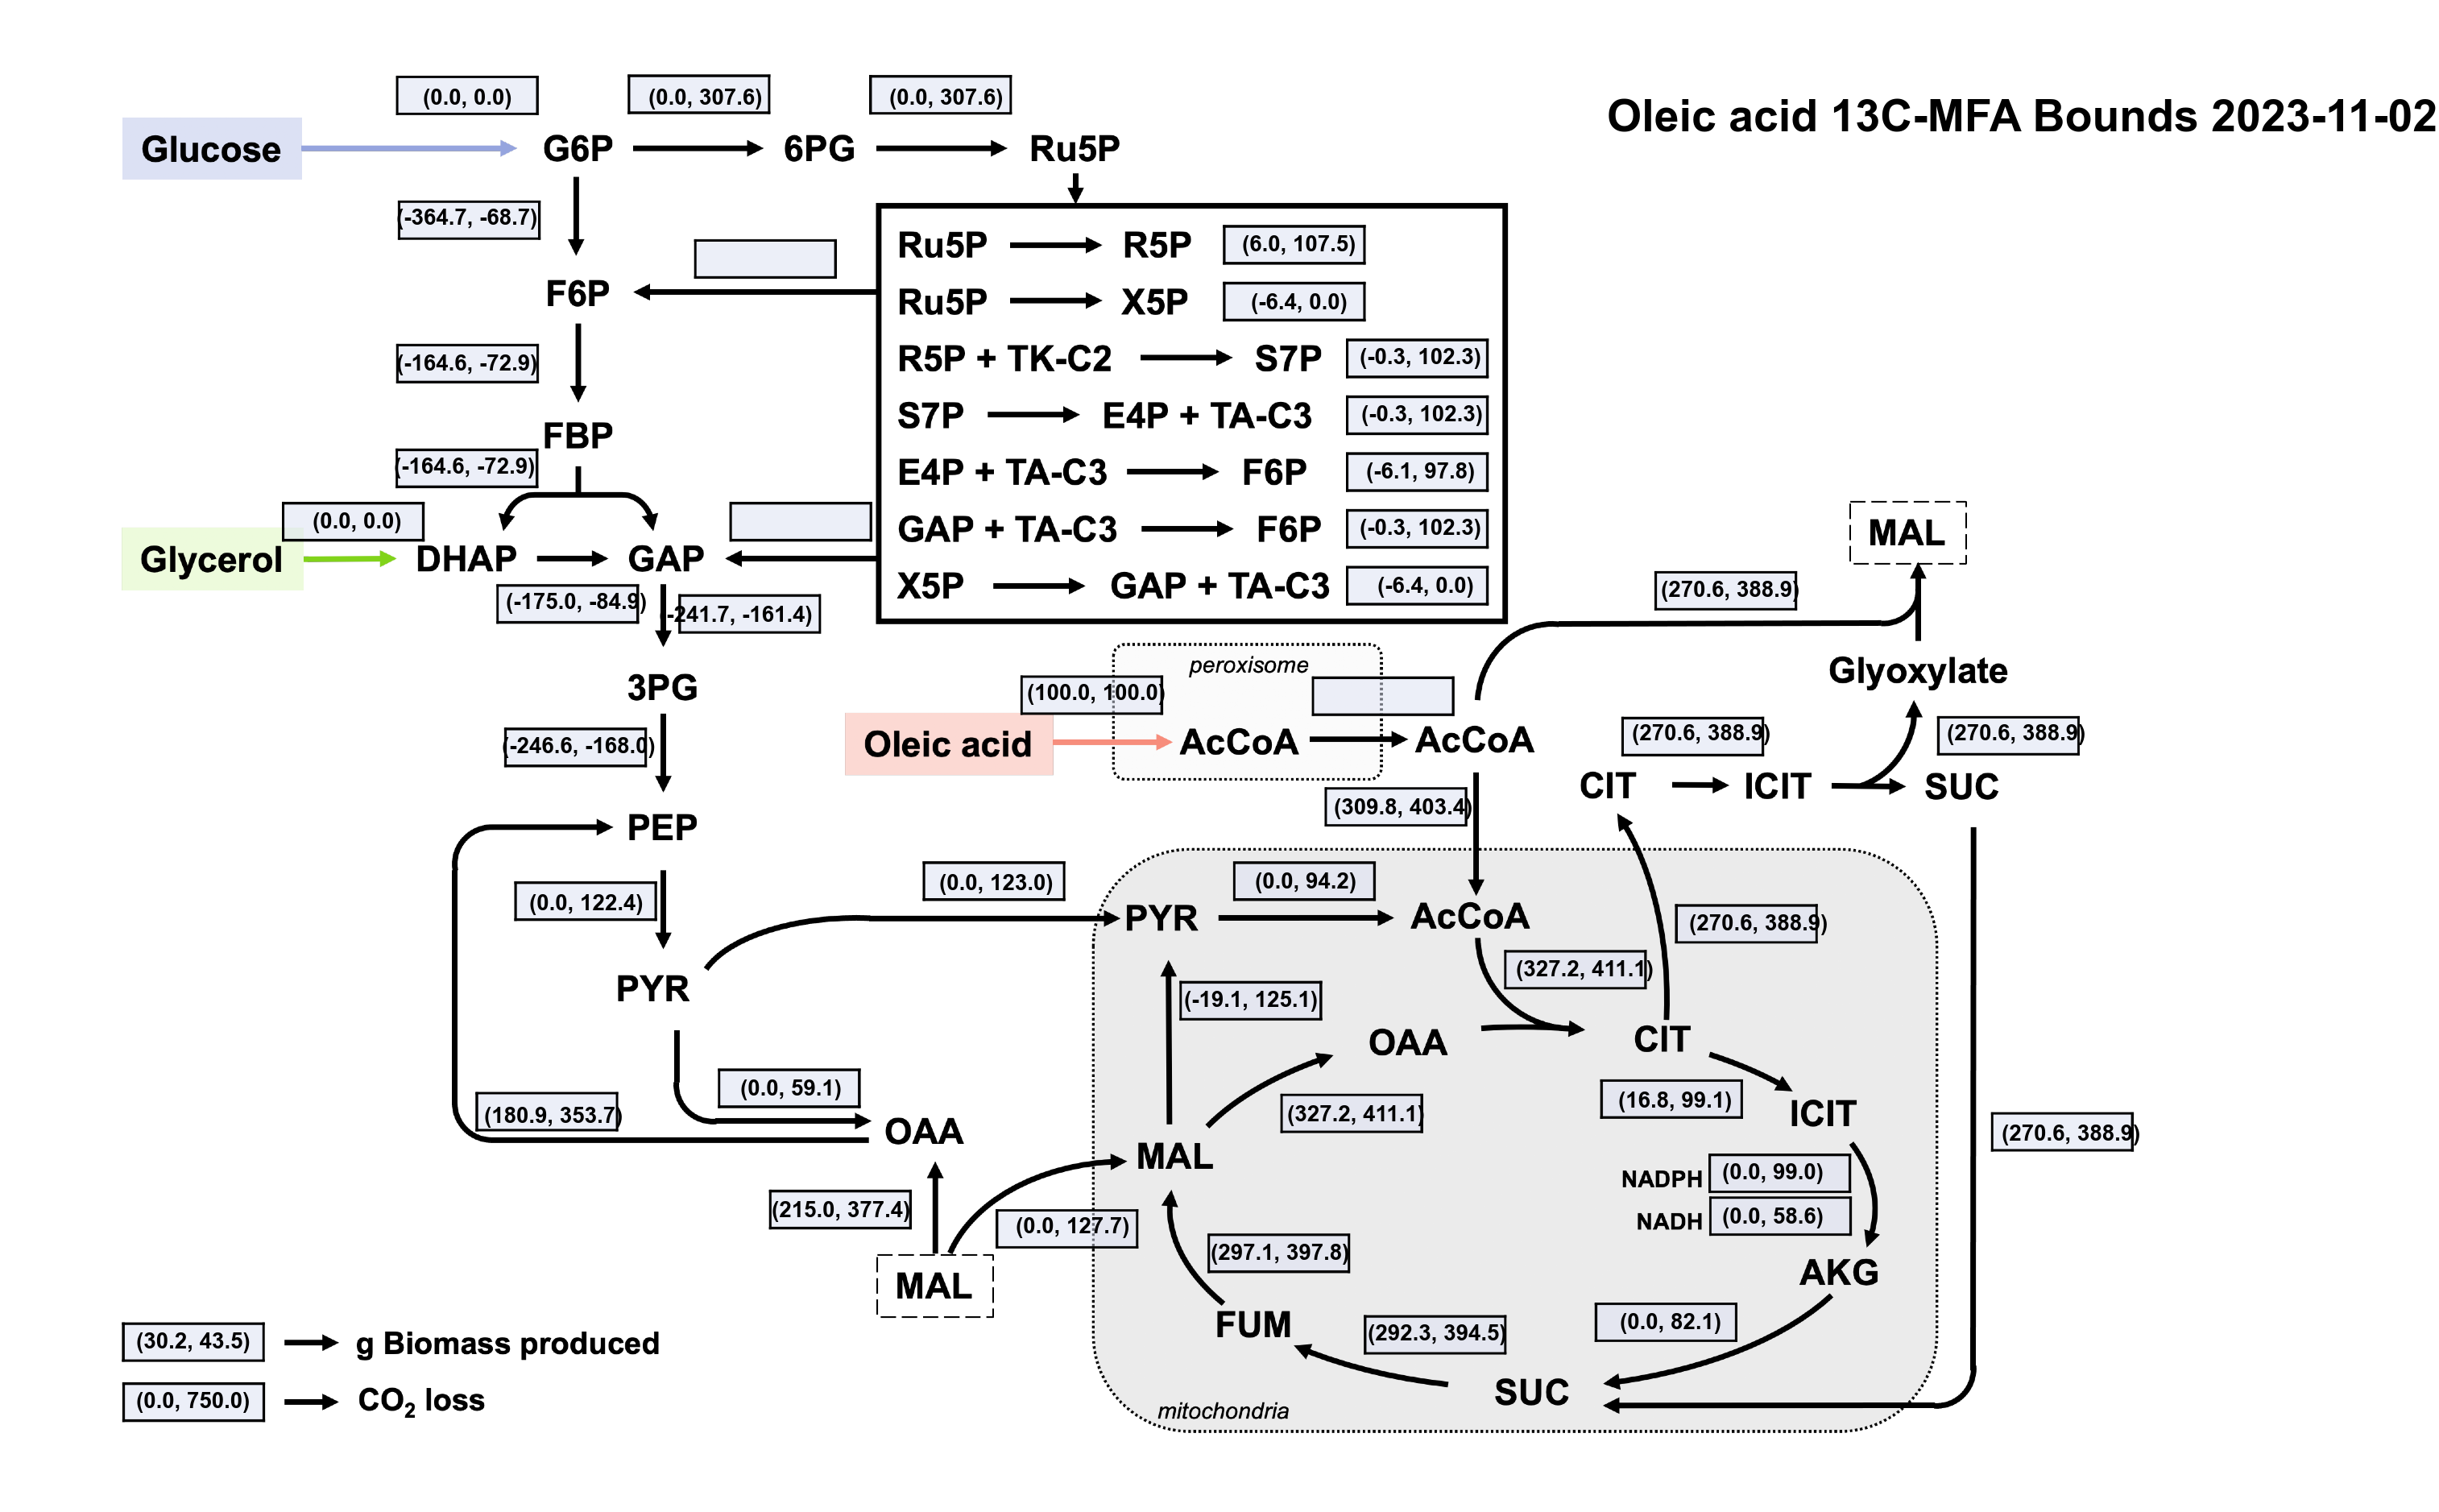

In [26]:
# Plot oleic acid MFA Bounds
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column=['oleic_acid_LB', 'oleic_acid_UB'],
    title_string='Oleic acid 13C-MFA Bounds 2023-11-02',
    file_name='../figures/test_flux_map.png',
)

### Plot Oleic Acid FVA Bounds

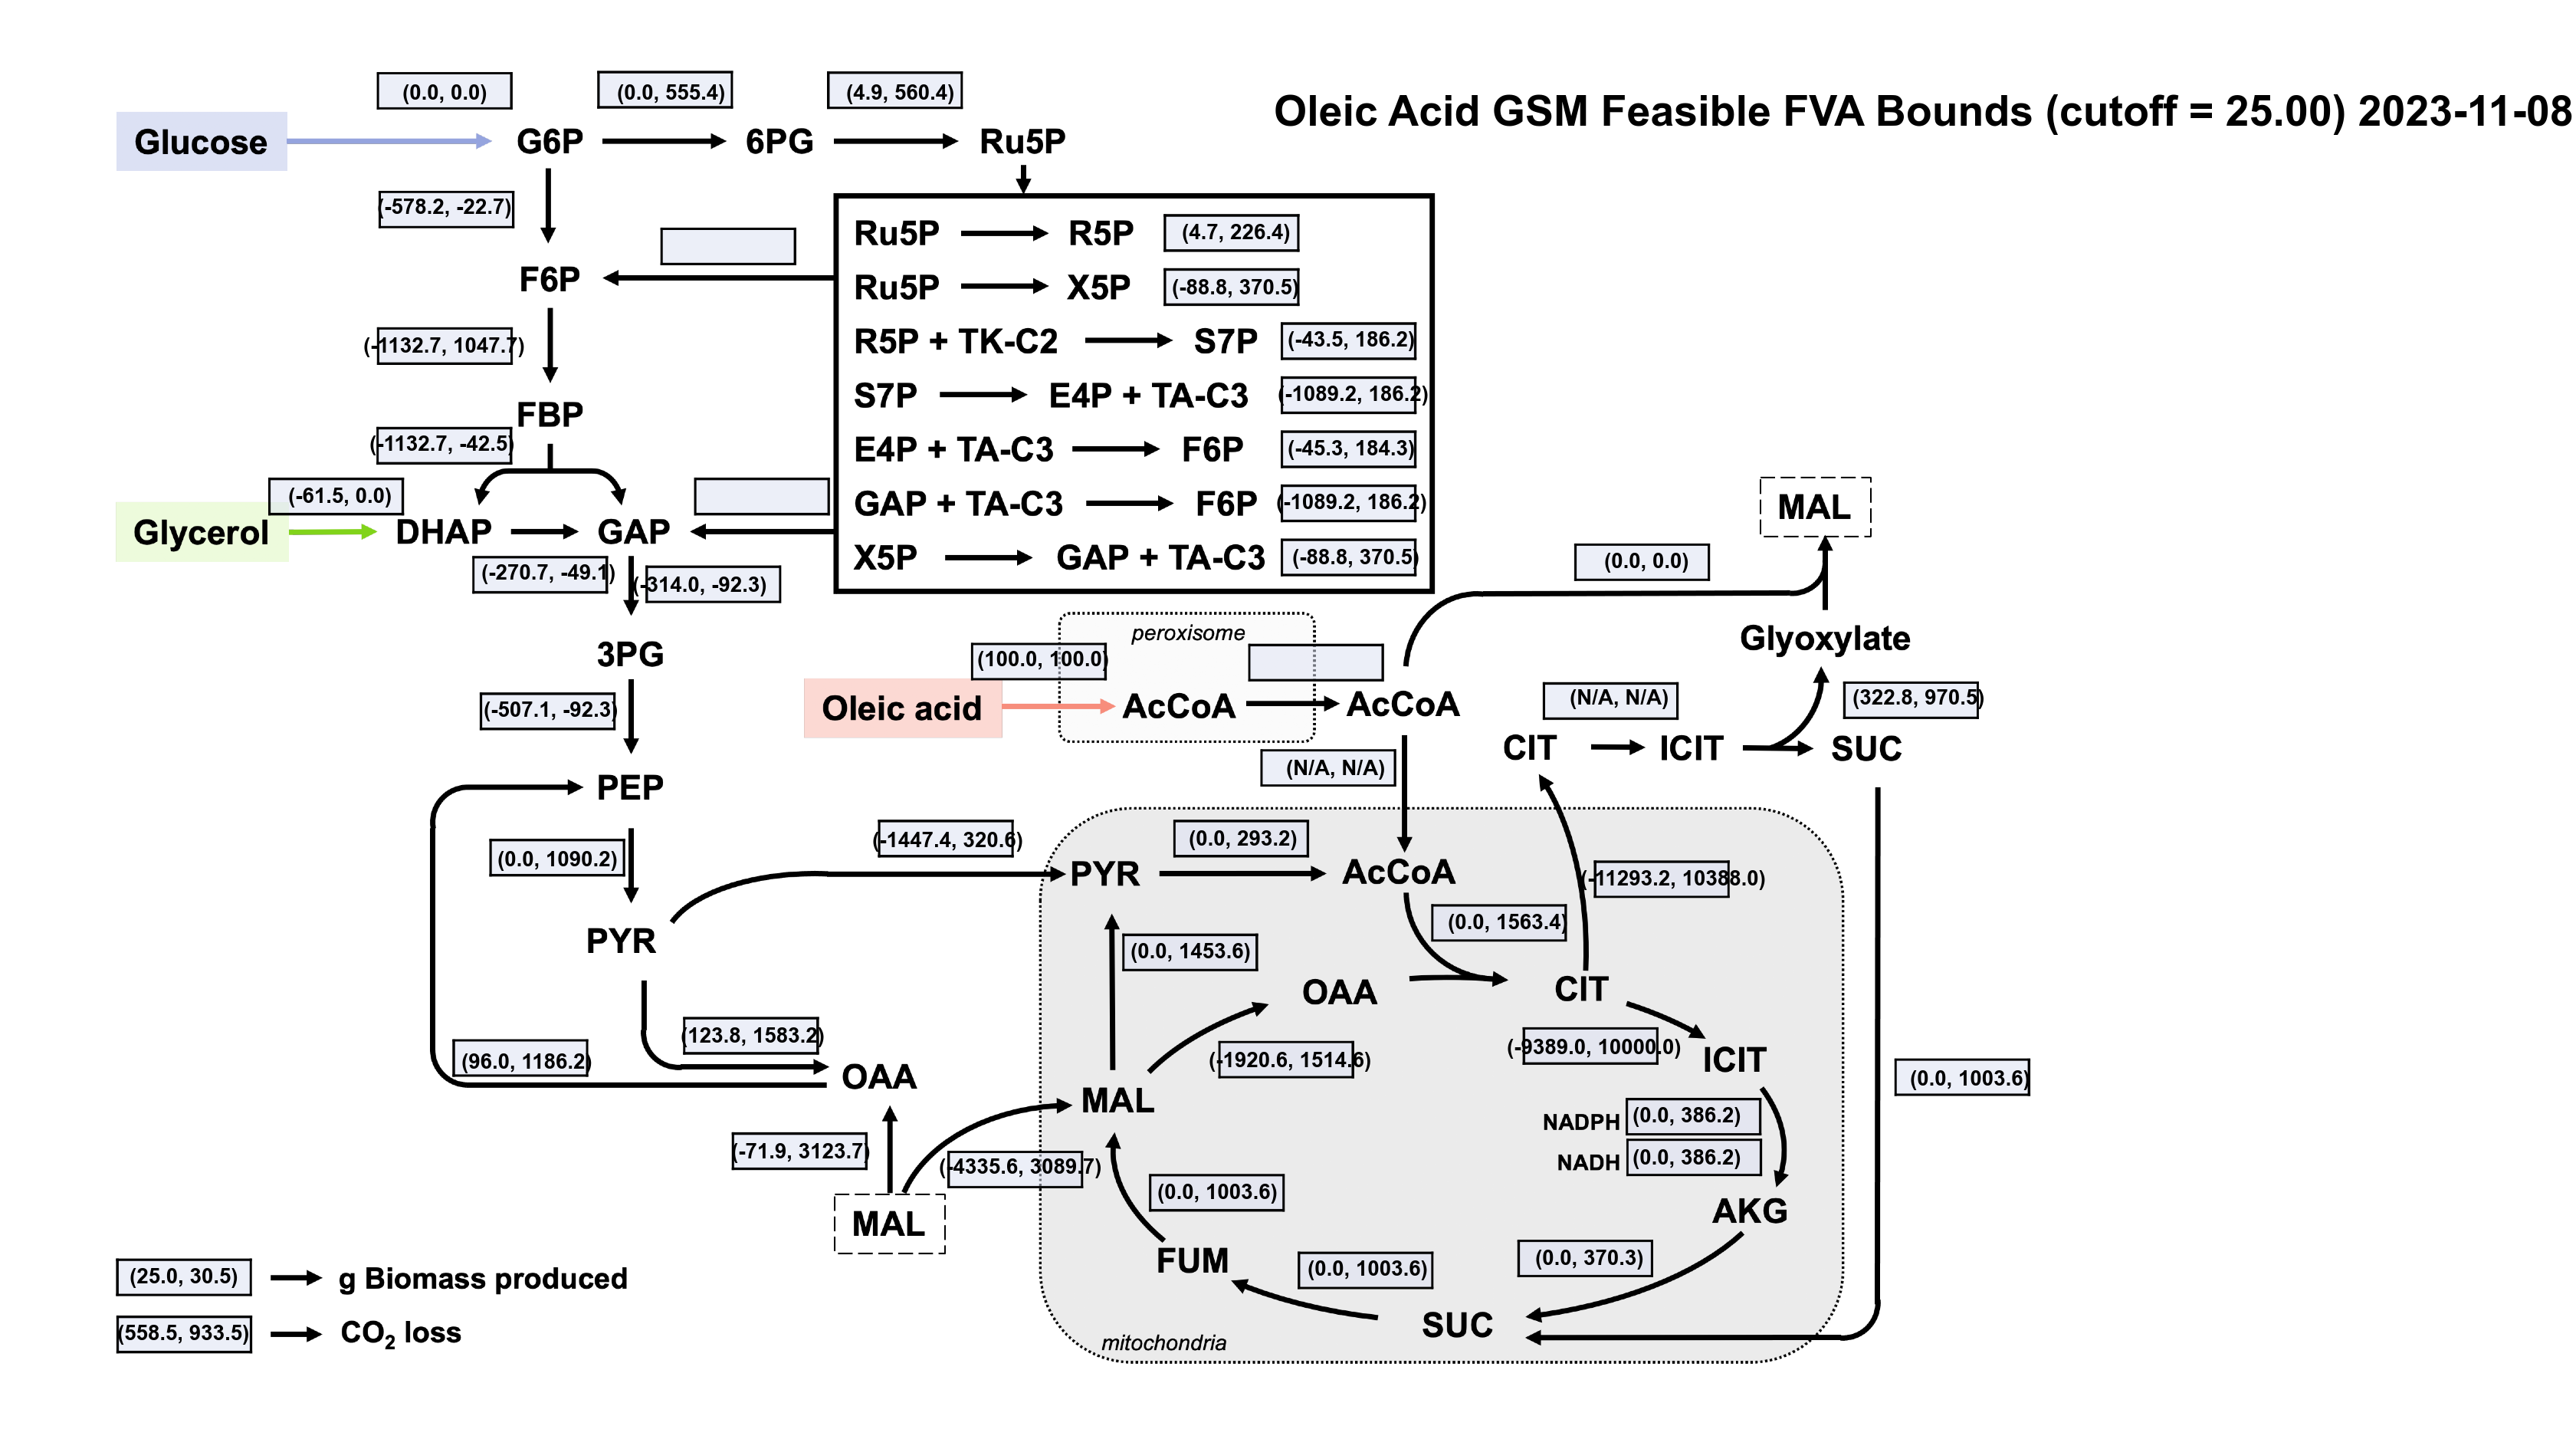

In [27]:
generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column=['oleic_acid_GSM_LB', 'oleic_acid_GSM_UB'],
    title_string=f'Oleic Acid GSM Feasible FVA Bounds (cutoff = {biomass_cutoff:.2f}) 2023-11-08',
    file_name='../figures/test_flux_map.png',
)

### Save the 13C-MFA bounds from the GSM

In [28]:
# reorder the columns so the the GSM flux columns are next to the 13C flux columns
full_central_rxn_df = full_central_rxn_df[[
    'Unnamed: 0', 'ID', 'Equation', 'reaction_ids', 'pathway', 'compartment', 
    'glucose_flux', 'glucose_LB', 'glucose_UB', 
    'glucose_GSM_flux', 'glucose_GSM_LB', 'glucose_GSM_UB', 'glucose_mfa_bound_feasibility',
    'glycerol_flux', 'glycerol_LB', 'glycerol_UB',
    'glycerol_GSM_flux', 'glycerol_GSM_LB', 'glycerol_GSM_UB', 'glycerol_mfa_bound_feasibility',
    'oleic_acid_flux', 'oleic_acid_LB', 'oleic_acid_UB',
    'oleic_acid_GSM_flux', 'oleic_acid_GSM_LB', 'oleic_acid_GSM_UB', 'oleic_acid_mfa_bound_feasibility'
]]

full_central_rxn_df

Unnamed: 0           ID  \
0                      uptake       uptake   
1                      uptake    R3 glyc3p   
2                      uptake  R3 dhap net   
3                      uptake    OA uptake   
4   glycolysis/gluconeogensis       R4 net   
..                        ...          ...   
66          biomass formation          R80   
67          energy metabolism          R81   
68          energy metabolism          R82   
69          energy metabolism          R83   
70              co2_formation          R79   

                                     Equation  \
0                        Glucose + ATP -> G6P   
1                        GLYC + ATP -> Glyc3P   
2                      Glyc3P <-> DHAP + UQH2   
3   OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2   
4                                 G6P <-> F6P   
..                                        ...   
66                                        NaN   
67                     ATP -> ATP_maintenance   
68                              NADH -> NADPH   
69                              NADH -> 2*ATP   
70                              CO2 -> CO2_EX   

                                   reaction_ids            pathway  \
0                              reverse_EX_glc_e   substrate_uptake   
1                                 reverse_GLYCt                emp   
2                                           NaN                emp   
3                                       OCDCEAt   substrate_uptake   
4                                           PGI                emp   
..                                          ...                ...   
66  biomass_C or biomass_glucose or biomass_oil  biomass_formation   
67                                         ATPM  energy_metabolism   
68                                          NaN                NaN   
69                                          NaN                NaN   
70                                 reverse_CO2t          transport   

      compartment  glucose_flux  glucose_LB  glucose_UB glucose_GSM_flux  ...  \
0         cytosol      100.0000    100.0000    100.0000            100.0  ...   
1         cytosol           NaN         NaN         NaN              0.0  ...   
2         cytosol           NaN         NaN         NaN                   ...   
3         cytosol           NaN         NaN         NaN              0.0  ...   
4         cytosol       19.0701      9.1106     26.4376         29.43415  ...   
..            ...           ...         ...         ...              ...  ...   
66        cytosol       11.2586      9.8463     12.2947        12.749805  ...   
67        cytosol      613.4628    436.2967    860.2141              0.0  ...   
68            NaN       33.5917      0.0000     66.8334                   ...   
69            NaN      280.3469    210.3067    373.4674                   ...   
70  extracellular      198.2584    161.2777    248.6371         183.2194  ...   

   glycerol_GSM_LB glycerol_GSM_UB glycerol_mfa_bound_feasibility  \
0              0.0             0.0                                  
1            100.0           100.0                 fully feasible   
2                                                                   
3              0.0             0.0                                  
4       -44.017481       -3.894065             partially feasible   
..             ...             ...                            ...   
66             5.0        5.189712                   not feasible   
67             0.0       27.587362                   not feasible   
68                                                                  
69                                                                  
70       37.295208       50.826968                   not feasible   

    oleic_acid_flux  oleic_acid_LB  oleic_acid_UB oleic_acid_GSM_flux  \
0               NaN            NaN            NaN                 0.0   
1               NaN            NaN            NaN                 0.0   
2              

In [29]:
# save the full central rxn df
full_central_rxn_df.to_csv('../results/central_fluxes/mfa_bounds_from_gsm.csv')